<div class="alert alert-block alert-success">

<a class="anchor" id="1st-bullet">    </a>
## 1. Import necessary libraries & Data Preprocessed and Functions
    

    
</div>

In [284]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.patches import RegularPolygon
import matplotlib.colors as mpl_colors
import matplotlib.colorbar as colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

from math import ceil
from collections import Counter
from sklearn.metrics import pairwise_distances

from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score
from scipy.stats import zscore
from sklearn.cluster import KMeans, AgglomerativeClustering,MeanShift, estimate_bandwidth, DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')
sns.set_style(style="whitegrid")


In [285]:
# import data preprocessed
df_preprocessed = pd.read_csv("data_preprocessed.csv")
df_preprocessed.head(2)

customer_id  customer_region  customer_age  vendor_count  product_count  \
0  1b8f824d5e             2360          18.0             2              5   
1  5d272b9dcb             8670          17.0             2              2   

   is_chain  first_order  last_order last_promo payment_method  ...  \
0         1          0.0           1   DELIVERY           DIGI  ...   
1         2          0.0           1   DISCOUNT           DIGI  ...   

   HR_afternoon  HR_evening  Weekdays  Weekend  total_spent  total_orders  \
0             2         0.0         0        2        28.88             2   
1             0         0.0         0        2        19.21             2   

   avg_spending_per_order  chain_order_ratio  preferred_cui  \
0                  14.440                0.5     CUI_Indian   
1                   9.605                1.0   CUI_American   

   preferred_cui_type  
0       Asian_Cuisine  
1     Western_Cuisine  

[2 rows x 74 columns]

In [286]:
df_preprocessed.drop(columns="customer_id", inplace=True) # it´s easier to have customers id as 0,1,2 for clusters.
df_preprocessed.head(1)

customer_region  customer_age  vendor_count  product_count  is_chain  \
0             2360          18.0             2              5         1   

   first_order  last_order last_promo payment_method  CUI_American  ...  \
0          0.0           1   DELIVERY           DIGI           0.0  ...   

   HR_afternoon  HR_evening  Weekdays  Weekend  total_spent  total_orders  \
0             2         0.0         0        2        28.88             2   

   avg_spending_per_order  chain_order_ratio  preferred_cui  \
0                   14.44                0.5     CUI_Indian   

   preferred_cui_type  
0       Asian_Cuisine  

[1 rows x 73 columns]

<a class="anchor" id="3rd-bullet">

### Functions:
</a>

In [287]:


# Calculate R2 and see the score
def get_sst(df): 
    """
    Calculates the sum of squared distances of each point to the mean of the points
    """
    return np.sum(df.var() * (df.count() - 1))

def get_r2_score(df, labels):
    """
    Calculates the proportion of variance explained by the clustering (r2)
    """
    sst = get_sst(df)
    ssw = np.sum(df.groupby(labels).apply(get_sst))
    ssb = sst - ssw
    return ssb / sst

# Hierarchical Clustering
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, metric="euclidean"):
    sst = get_sst(df)
    
    r2 = []  
    for i in range(min_nclus, max_nclus+1):
        cluster = AgglomerativeClustering(n_clusters=i, metric=metric, linkage=link_method)
        hclabels = cluster.fit_predict(df) 
        df_concat = df.copy()
        df_concat['labels'] = hclabels
        r2.append(get_r2_score(df_concat, 'labels'))
        
    return np.array(r2)

def hierarchical_clustering_methods_nclust_analysis(dataframe, hc_methods, max_nclus, metric="euclidean"):
    r2_hc_methods = np.vstack(
        [
            get_r2_hc(dataframe, link, max_nclus, metric=metric)
            for link in hc_methods
        ]
    ).T

    r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

    sns.set()
    fig = plt.figure(figsize=(11, 5))
    sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)
    fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
    plt.legend(title="HC methods", title_fontsize=11)
    plt.xticks(range(1, max_nclus + 1))
    plt.xlabel("Number of clusters", fontsize=13)
    plt.ylabel("R2 metric", fontsize=13)
    plt.show()

# Plot dendrogram
def plot_dendrogram(dataframe, y_threshold, linkage="ward", metric='euclidean'):
    hclust = AgglomerativeClustering(linkage=linkage, metric=metric, distance_threshold=0, n_clusters=None)
    hclust.fit(dataframe)

    counts = np.zeros(hclust.children_.shape[0])
    n_samples = len(hclust.labels_)

    for i, merge in enumerate(hclust.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack(
        [hclust.children_, hclust.distances_, counts]
    ).astype(float)

    sns.set()
    fig = plt.figure(figsize=(11, 5))
    dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
    plt.hlines(y_threshold, 0, plt.gca().get_xlim()[1], colors="r", linestyles="dashed")
    plt.title(f'Hierarchical Clustering - {linkage} | Dendrogram', fontsize=21)
    plt.xlabel('Number of points in node (or index of point if no parenthesis)')
    plt.ylabel(f'{metric} Distance', fontsize=13)
    plt.show()

# K-Means
def plot_inertia_silhouette_scores(dataframe, min_clust, max_clust):
    range_clusters = range(min_clust, max_clust + 1)

    inertia = []
    avg_silhouette = []
    for n_clus in range_clusters:
        kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
        cluster_labels = kmclust.fit_predict(dataframe)
        inertia.append(kmclust.inertia_)
        silhouette_avg = silhouette_score(dataframe, cluster_labels)
        avg_silhouette.append(silhouette_avg)

    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_size_inches(18.5, 8)
    
    ax1.plot(range_clusters, inertia, marker='o')
    ax1.set_title('Inertia plot over clusters')
    ax1.set_ylabel("Inertia: SSw")
    ax1.set_xlabel("Number of clusters")
    ax1.set_xticks(np.arange(min_clust, max_clust + 1, 1))
    
    ax2.plot(range_clusters, avg_silhouette, marker='o')
    ax2.set_title('Average silhouette plot over clusters')
    ax2.set_ylabel("Average silhouette")
    ax2.set_xlabel("Number of clusters")
    ax2.set_xticks(np.arange(min_clust, max_clust + 1, 1))
    
    plt.show()

# Comparison of R2 scores
def plot_models_r2_nclust(models_dict, lower_lim):
    scores = []
    n_clusters = []
    for modelName, modelDataframe in models_dict.items():
        scores.append(get_r2_score(modelDataframe, 'labels'))
        n_clusters.append(len(np.unique(modelDataframe['labels'])))
        
    sns.set()
    f, (ax1, ax2) = plt.subplots(1, 2)
    f.set_size_inches(18.5, 12.5)
    
    x = np.arange(len(scores))  # the label locations
    
    width = 0.20  # the width of the bars
    ax1.set_facecolor("white")
    ax1.bar(x - width/2, scores, width, color="#4A7A89")
    ax1.set_ylim(lower_lim, 1.0)
    ax1.set_ylabel('Scores', fontsize=14)
    ax1.set_title('R-Squared score by Model', fontsize=16)
    ax1.set_xticks(x)
    ax1.set_xticklabels(models_dict.keys(), fontsize=14)
    
    ax2.set_facecolor("white")
    ax2.bar(x - width/2, n_clusters, width, color="#4A7A89")
    ax2.set_ylabel('Number of Clusters', fontsize=14)
    ax2.set_title('Number of Clusters by Model', fontsize=16)
    ax2.set_xticks(x)
    ax2.set_xticklabels(models_dict.keys(), fontsize=14)
    plt.show()

# Cluster visualization
def plot_2dClusters(df_reduced, models_dict): 
    f, ax = plt.subplots(2, 3, sharey=True)
    f.set_size_inches(18.5, 12.5)
    xlabel = df_reduced.columns[0]
    ylabel = df_reduced.columns[1]
    j = 0
    i = 0
    for modelName, modelDataframe in models_dict.items():
        labels = modelDataframe['labels']
        if j == 3:
            i += 1
            j = 0
        ax[i][j].set_title(modelName, fontsize=15)
        ax[i][j].set_xlabel(xlabel, fontsize=15)
        ax[i][j].set_ylabel(ylabel, fontsize=15)
        ax[i][j].scatter(df_reduced.iloc[:, 0], df_reduced.iloc[:, 1], c=labels, cmap='tab20', s=2)
        j += 1
    plt.show()

# Access feature importance and reclassifying outliers
def get_ss_var(df):
    ss = df.var() * (df.count() - 1)
    return ss  # return sum of sum of squares of each df variable.

def get_r2_variables(df, labels_name):
    df_temp = df.copy()
    df_temp.drop(labels_name, axis=1, inplace=True)
    
    sst = get_ss_var(df_temp)
    ssw_labels = np.sum(df.groupby(labels_name).apply(get_ss_var))
    return 1 - ssw_labels / sst


<div class="alert alert-block alert-success">

<a class="anchor" id="1st-bullet">    </a>
## 2. Kmeans and HC different perspectives:
    

    
</div>

<a class="anchor" id="3rd-bullet">

### Scale Data and define some functions and perspetives:    
</a>

In [288]:
df_preprocessed.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'Sunday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'HR_0',
       'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9',
       'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17',
       'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'age_category',
       'Western_Cuisine', 'Asian_Cuisine', 'Complementary_Cuisine',
       'Other_Cuisines', 'chain_frequency', 'HR_breakfast', 'HR_lunch_dinner',
       'HR_afternoon', 'HR_evening', 'Weekdays', 'Weekend', 'total_spent',
       'total_orders',

In [289]:
value_perspetive = ['total_spent', 'avg_spending_per_order', 'last_order']
behaviour_features = ['Weekdays', 'is_chain', 'HR_breakfast', 'HR_lunch_dinner', 'HR_afternoon', 'HR_evening']
preference_features = ['Western_Cuisine', 'Asian_Cuisine', 'Complementary_Cuisine', 'Other_Cuisines']

**After having final clusters we will associate categorical variables to each cluster (customer region, age_category, payment_method)**

In [290]:
metric_features = value_perspetive + behaviour_features + preference_features

In [291]:
# copy of preprocessed to df (scaled one)
df = df_preprocessed.copy()

# List of columns to exclude from scaling
exclude_columns = ["customer_region", "last_promo", "payment_method", "age_category", "chain_frequency", "preferred_cui_type", "preferred_cui"]

# Determine the columns to scale by excluding the specified columns
columns_to_scale = [col for col in df_preprocessed.columns if col not in exclude_columns]

# Instantiate the StandardScaler, fit and transform
ss_scaler = StandardScaler()
ss_scaled_feat = ss_scaler.fit_transform(df[columns_to_scale])

# Update the df with the scaled values
df[columns_to_scale] = ss_scaled_feat

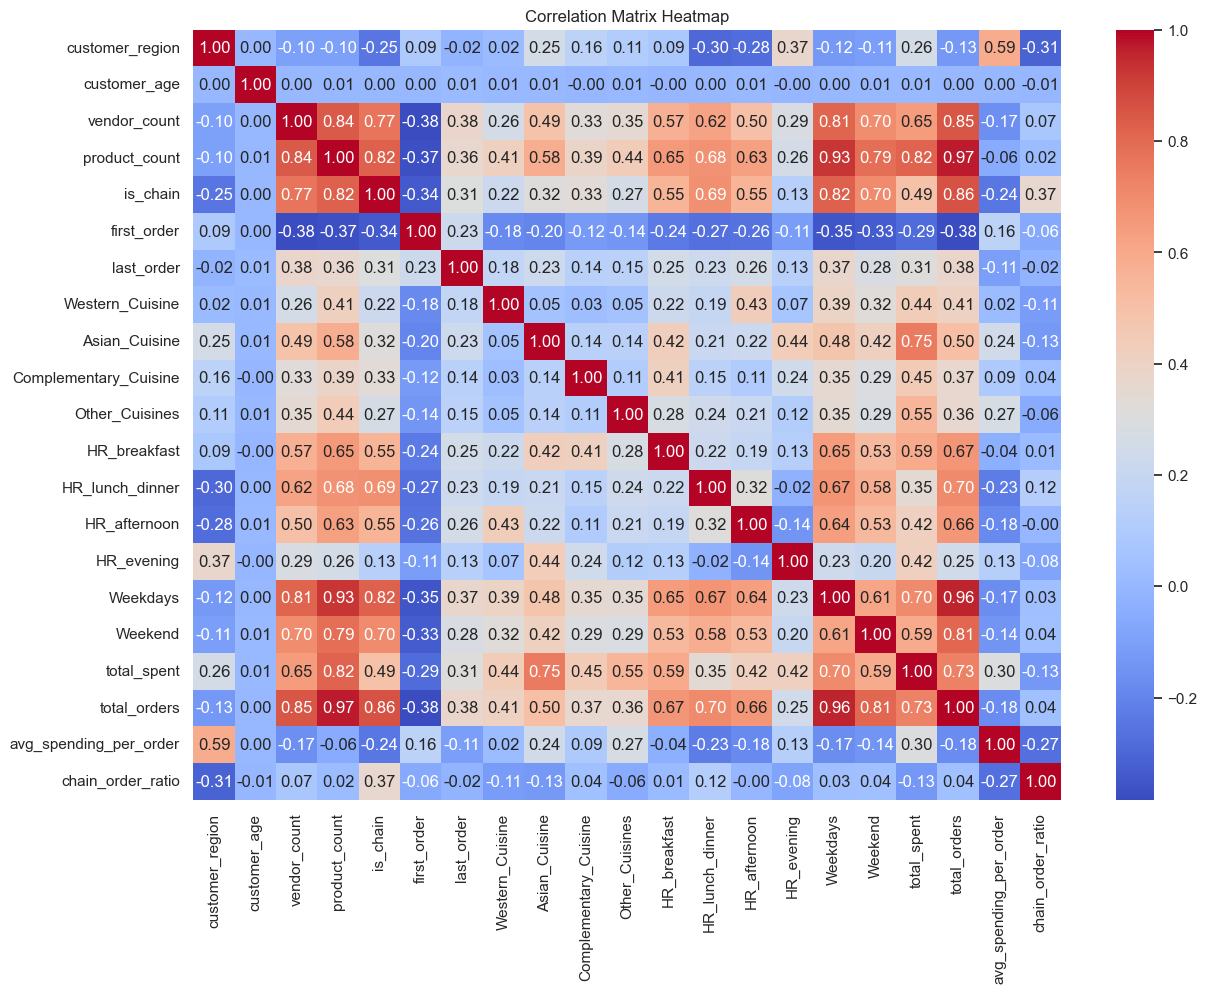

In [292]:
# Define the columns to exclude from the correlation calculation
exclude_columns = ['last_promo', 'payment_method', 'age_category', 'chain_frequency', 'preferred_cui_type', 'preferred_cui',
                   "HR_0", "HR_1", "HR_2", "HR_3", "HR_4", "HR_5", "HR_6", "HR_7", "HR_8", "HR_9", "HR_10",
                   "HR_11", "HR_12", "HR_13", "HR_14", "HR_15", "HR_16", "HR_17", "HR_18", "HR_19", "HR_20",
                   "HR_21", "HR_22", "HR_23", "Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday",
                   "CUI_American", "CUI_Asian", "CUI_Cafe", "CUI_Beverages", "CUI_Chicken Dishes", "CUI_Chinese", "CUI_Desserts",
                    "CUI_Healthy","CUI_Indian","CUI_Italian","CUI_Japanese","CUI_Noodle Dishes","CUI_OTHER","CUI_Street Food / Snacks","CUI_Thai"]


# Drop the columns to exclude
df_filtered = df.drop(columns=exclude_columns)

# Compute the correlation matrix
correlation_matrix = df_filtered.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

Assess the correlations 


<a class="anchor" id="3rd-bullet">

### Value / RFM perspective
</a>

In [293]:
value_perspetive = ['total_spent', 'avg_spending_per_order', 'last_order']
df_value = df[value_perspetive].copy()

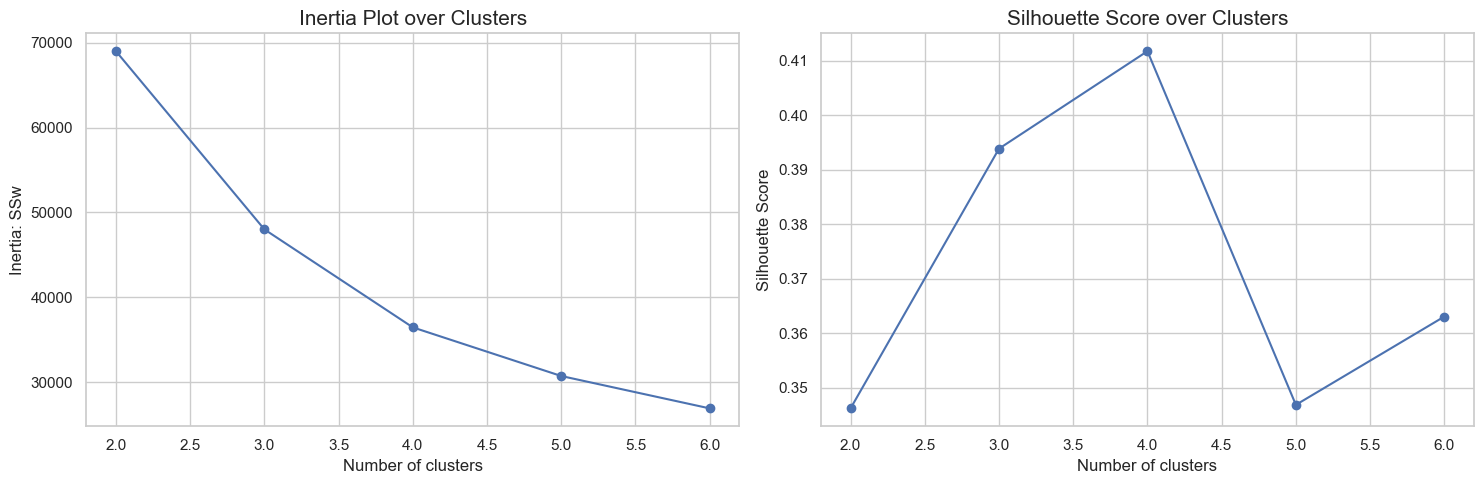

In [294]:
# Define the range of clusters to evaluate
range_clusters = range(2, 7)  # Silhouette score is not defined for 1 cluster

# Initialize lists to store inertia and silhouette scores
inertia = []
silhouette_scores = []

for n_clus in range_clusters:  # iterate over each cluster
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=15)
    cluster_labels = kmclust.fit_predict(df_value)
    inertia.append(kmclust.inertia_)  # add the inertia of the given cluster solution
    silhouette_avg = silhouette_score(df_value, cluster_labels)
    silhouette_scores.append(silhouette_avg)  # add the silhouette score of the given cluster solution

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot inertia (elbow plot)
ax1.plot(range_clusters, inertia, marker='o')
ax1.set_title("Inertia Plot over Clusters", size=15)
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Inertia: SSw")

# Plot silhouette scores
ax2.plot(range_clusters, silhouette_scores, marker='o')
ax2.set_title("Silhouette Score over Clusters", size=15)
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Silhouette Score")

# Show the plots
plt.tight_layout()
plt.show()


In [295]:
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=15)
kmclust.fit(df_value) #performs clustering ie finds centroids

KMeans(n_clusters=4, n_init=15, random_state=15)

In [296]:
#location of each point
dist_matrix = pd.DataFrame(kmclust.transform(df_value)) #calculates distance of each sample to respective centroid

In [297]:
km_labels = kmclust.predict(df_value) #associates/predicts cluster index for each sample, based on min distance

In [298]:
# Characterizing the final clusters
df_concat = pd.concat([df_value, pd.Series(km_labels, name='value_labels')], axis=1)

# Calculate the mean values for each cluster
df_centroids = df_concat.groupby('value_labels').mean()

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled

In [299]:
pd.DataFrame(km_labels)[0].value_counts()

0
0    18142
2     7763
1     3443
3     2369
Name: count, dtype: int64

In [300]:
df['value_labels'] = df_concat['value_labels'] # adds labels to scale df

In [301]:
df['value_labels'].value_counts()

value_labels
0    18142
2     7763
1     3443
3     2369
Name: count, dtype: int64

In [302]:
# using R^2
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss # return sum of sum of squares of each df variable

sst = get_ss(df_value) # get total sum of squares
ssw_labels = df_concat.groupby(['value_labels']).apply(get_ss) # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)
r2 = ssb / sst
print('R^2 Score: ', round(r2,3))

R^2 Score:  0.617


In [303]:
silhoutte_score = silhouette_score(df_value, km_labels, random_state=15)

print('Silhouette Score: ', round(silhoutte_score,3))

Silhouette Score:  0.412


In [304]:
calinski_harabasz = calinski_harabasz_score(df_value, km_labels)
print('Calinski Harabasz Score: ', round(calinski_harabasz,3))

Calinski Harabasz Score:  17013.886


This high result indicates that results are well distributed.

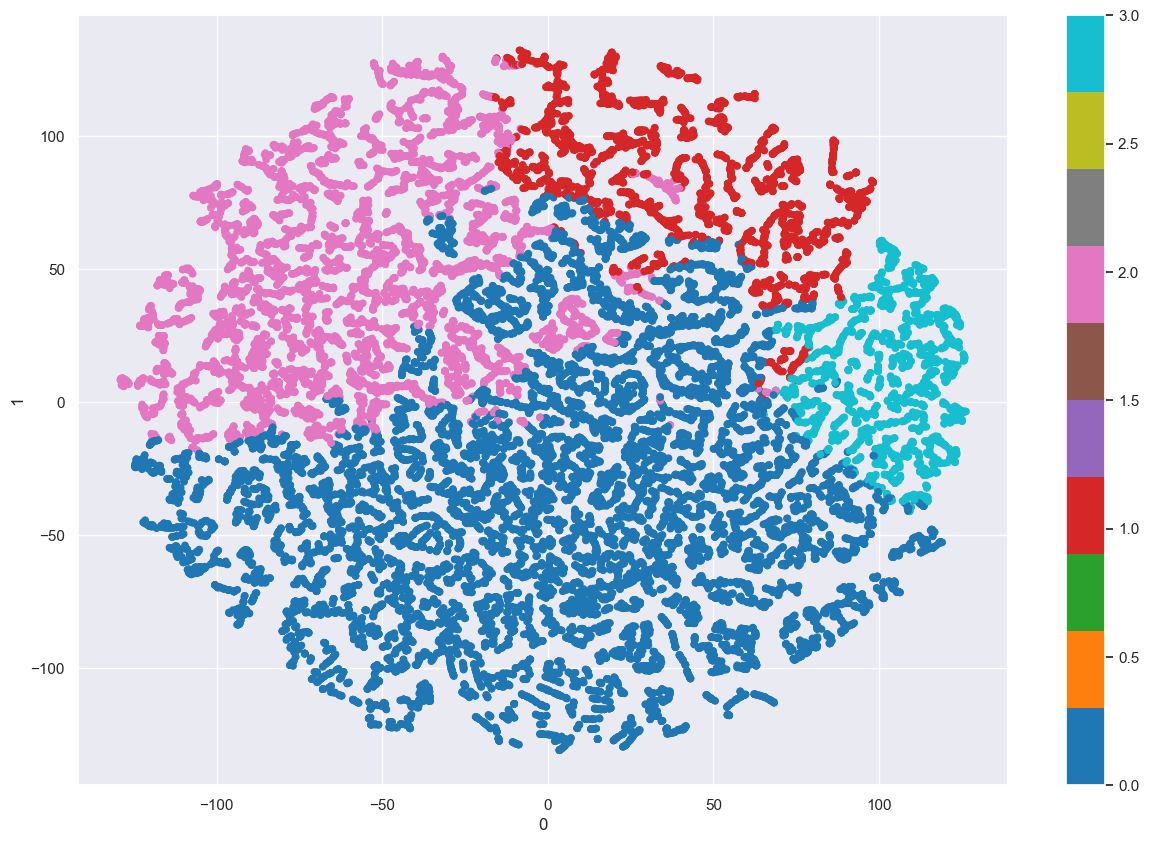

In [373]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42, perplexity=12).fit_transform(df_value)

# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['value_labels'], colormap='tab10', figsize=(15,10))
plt.show()

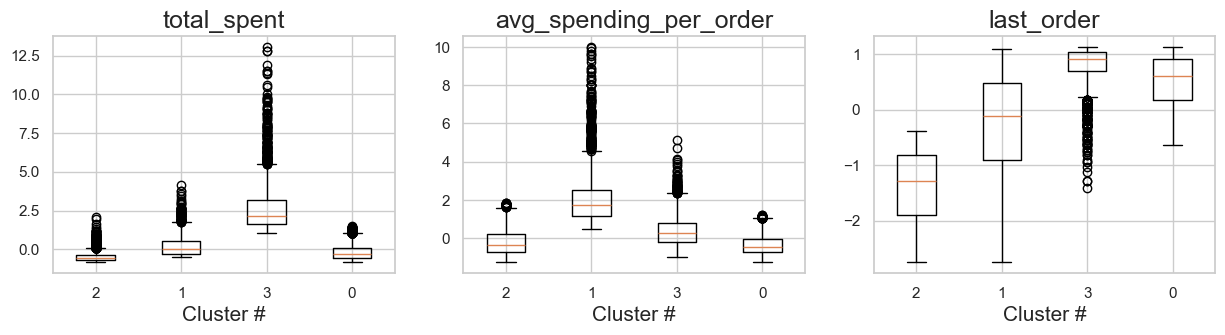

In [385]:
df_concat_value = df.set_index("value_labels")

# Select the columns for plotting
df_plots = df_value

# Set the style for seaborn
sns.set()
sns.set_style(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

# Iterate over each variable and create boxplots
for ax, variable in zip(axes.flatten(), df_plots.columns):
    my_dict = {str(label): df_concat_value.loc[label, variable].values for label in df_concat_value.index.unique()}
    ax.boxplot(my_dict.values())
    ax.set_title(variable, fontsize=18)
    ax.set_xlabel('Cluster #', fontsize=15)
    ax.set_xticklabels(my_dict.keys())

# Adjust the layout
plt.subplots_adjust(hspace=0.6, top=0.90)

# Show the plot
plt.show()


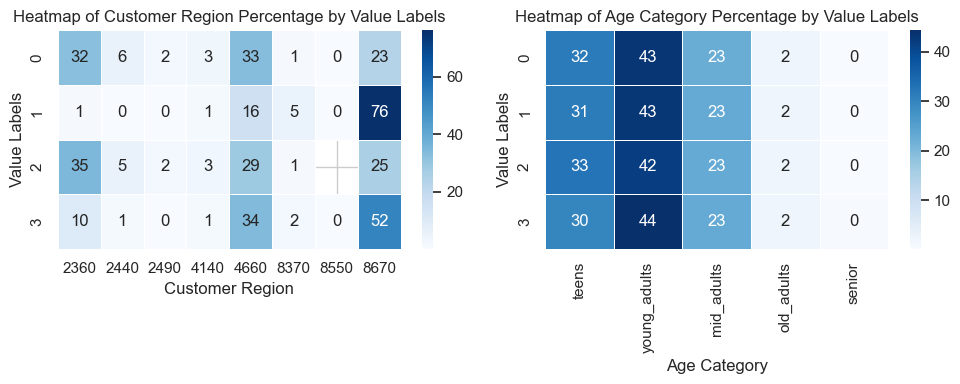

In [384]:
# Group by value_labels and customer_region
df_value_region = df.groupby(['value_labels', 'customer_region'])['customer_region'].size().unstack()

# Calculate the percentage distribution for customer_region
df_value_region_pct = df_value_region.copy()
for i in df['customer_region'].unique():
    df_value_region_pct[i] = 100 * df_value_region_pct[i] / df['value_labels'].value_counts().sort_index().values

# Group by value_labels and age_category
age_order = ['teens', 'young_adults', 'mid_adults', 'old_adults', 'senior']
df['age_category'] = pd.Categorical(df['age_category'], categories=age_order, ordered=True)
df_value_age = df.groupby(['value_labels', 'age_category'])['age_category'].size().unstack()

# Calculate the percentage distribution for age_category
df_value_age_pct = df_value_age.copy()
for i in df['age_category'].unique():
    df_value_age_pct[i] = 100 * df_value_age_pct[i] / df['value_labels'].value_counts().sort_index().values

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot heatmap for customer_region
sns.heatmap(df_value_region_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5, ax=axes[0])
axes[0].set_title('Heatmap of Customer Region Percentage by Value Labels')
axes[0].set_xlabel('Customer Region')
axes[0].set_ylabel('Value Labels')

# Plot heatmap for age_category
sns.heatmap(df_value_age_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5, ax=axes[1])
axes[1].set_title('Heatmap of Age Category Percentage by Value Labels')
axes[1].set_xlabel('Age Category')
axes[1].set_ylabel('Value Labels')

plt.tight_layout()
plt.show()


<a class="anchor" id="3rd-bullet">

### Preferences Perspective
</a>

In [306]:
df.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'Sunday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'HR_0',
       'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9',
       'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17',
       'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'age_category',
       'Western_Cuisine', 'Asian_Cuisine', 'Complementary_Cuisine',
       'Other_Cuisines', 'chain_frequency', 'HR_breakfast', 'HR_lunch_dinner',
       'HR_afternoon', 'HR_evening', 'Weekdays', 'Weekend', 'total_spent',
       'total_orders',

In [307]:
preference_features = [
    'Western_Cuisine',
    'Asian_Cuisine',
    'Complementary_Cuisine',
    'Other_Cuisines'
]

df_prf = df[preference_features].copy()

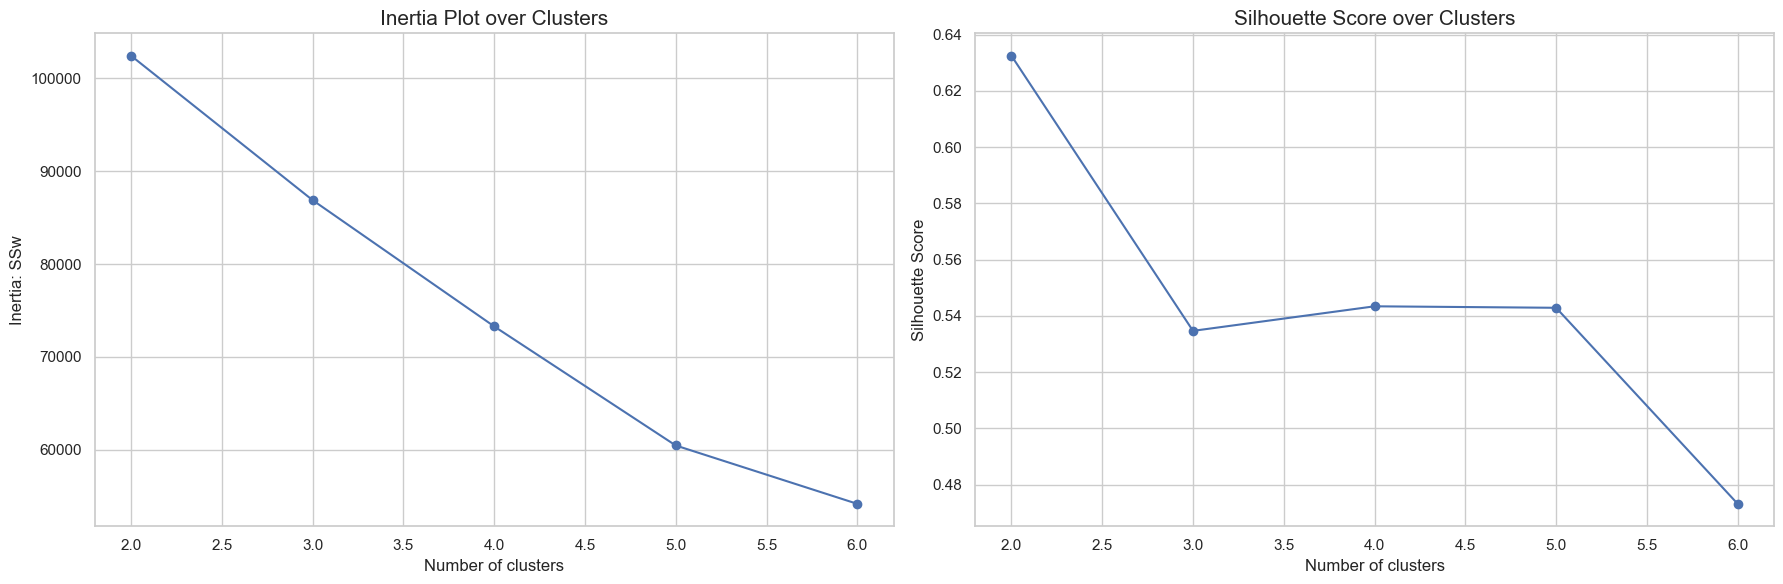

In [308]:
# Define the range of clusters to evaluate
range_clusters = range(2, 7)  # Silhouette score is not defined for 1 cluster

# Initialize lists to store inertia and silhouette scores
inertia = []
silhouette_scores = []

for n_clus in range_clusters:  # iterate over each cluster
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=15)
    cluster_labels = kmclust.fit_predict(df_prf)
    inertia.append(kmclust.inertia_)  # add the inertia of the given cluster solution
    silhouette_avg = silhouette_score(df_prf, cluster_labels)
    silhouette_scores.append(silhouette_avg)  # add the silhouette score of the given cluster solution

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot inertia (elbow plot)
ax1.plot(range_clusters, inertia, marker='o')
ax1.set_title("Inertia Plot over Clusters", size=15)
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Inertia: SSw")

# Plot silhouette scores
ax2.plot(range_clusters, silhouette_scores, marker='o')
ax2.set_title("Silhouette Score over Clusters", size=15)
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Silhouette Score")

# Show the plots
plt.tight_layout()
plt.show()

In [309]:
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=5, init='k-means++', n_init=15, random_state=15)
kmclust.fit(df_prf)

KMeans(n_clusters=5, n_init=15, random_state=15)

In [310]:
dist_matrix = pd.DataFrame(kmclust.transform(df_prf)) #calculates distance of each sample to respective centroid

In [311]:
km_labels = kmclust.predict(df_prf) #associates cluster index for each sample, based on min distance

In [312]:
# Characterizing the final clusters
df_concat = pd.concat([df_prf, pd.Series(km_labels, name='prf_labels')], axis=1)

# Calculate the mean values for each cluster
df_centroids = df_concat.groupby('prf_labels').mean()

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled

In [313]:
pd.DataFrame(km_labels)[0].value_counts() #not very well distributed between the 4 centroids

0
1    25748
2     2127
0     1691
3     1244
4      907
Name: count, dtype: int64

In [314]:
df['prf_labels'] = df_concat['prf_labels'] # adds labels to scale df
df['prf_labels'].value_counts()

prf_labels
1    25748
2     2127
0     1691
3     1244
4      907
Name: count, dtype: int64

In [315]:
# using R^2
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss # return sum of sum of squares of each df variable

sst = get_ss(df_prf) # get total sum of squares
ssw_labels = df_concat.groupby(['prf_labels']).apply(get_ss) # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels) # remember: SST = SSW + SSB
r2 = ssb / sst
print('R^2 Score: ', round(r2,3))

R^2 Score:  0.523


In [316]:
silhoutte_score = silhouette_score(df_prf, km_labels, random_state=15)

print('Silhouette Score: ', round(silhoutte_score,3))

Silhouette Score:  0.543


In [317]:
calinski_harabasz = calinski_harabasz_score(df_prf, km_labels)
print('Calinski Harabasz Score: ', round(calinski_harabasz,3))

Calinski Harabasz Score:  8703.973


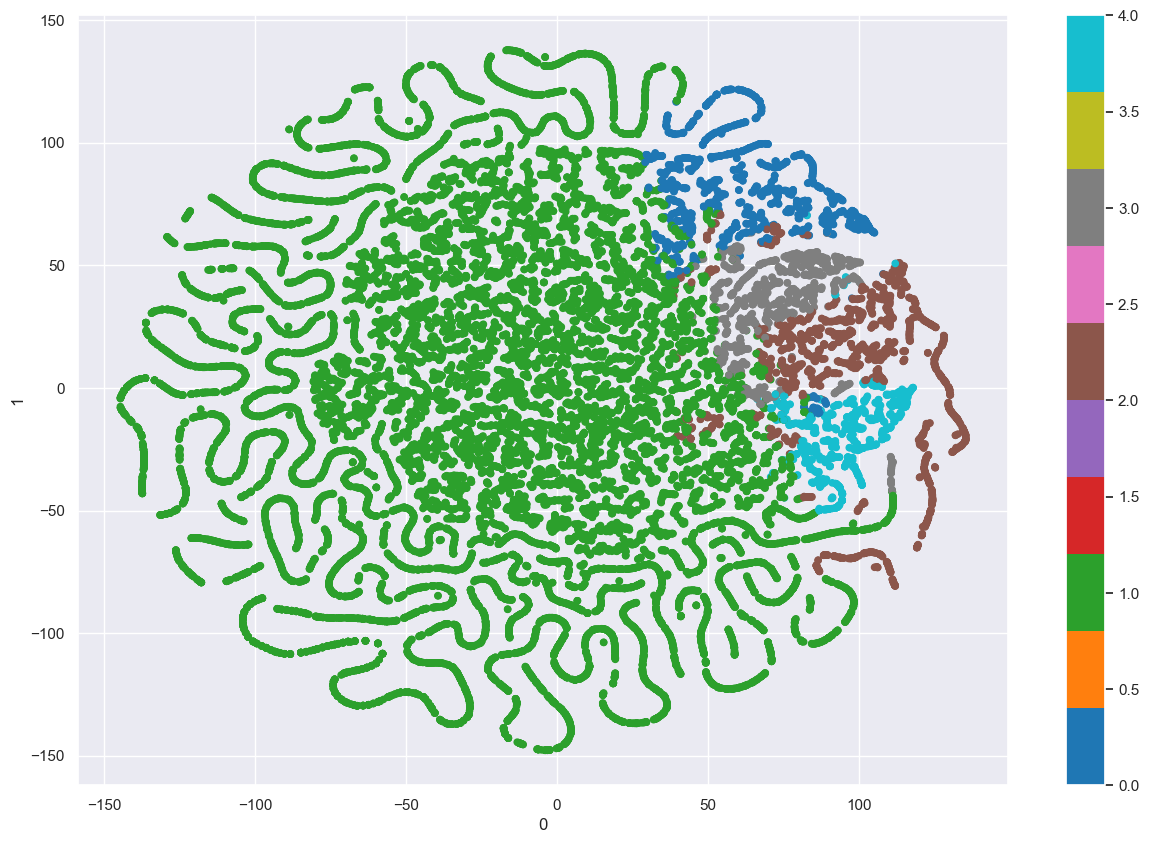

In [374]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42, perplexity=12).fit_transform(df_prf)

# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['prf_labels'], colormap='tab10', figsize=(15,10))
plt.show()

<a class="anchor" id="3rd-bullet">

### Behaviour/demographic Based Perspective
</a>

In [319]:
df.columns

Index(['customer_region', 'customer_age', 'vendor_count', 'product_count',
       'is_chain', 'first_order', 'last_order', 'last_promo', 'payment_method',
       'CUI_American', 'CUI_Asian', 'CUI_Beverages', 'CUI_Cafe',
       'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts', 'CUI_Healthy',
       'CUI_Indian', 'CUI_Italian', 'CUI_Japanese', 'CUI_Noodle Dishes',
       'CUI_OTHER', 'CUI_Street Food / Snacks', 'CUI_Thai', 'Sunday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'HR_0',
       'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7', 'HR_8', 'HR_9',
       'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15', 'HR_16', 'HR_17',
       'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23', 'age_category',
       'Western_Cuisine', 'Asian_Cuisine', 'Complementary_Cuisine',
       'Other_Cuisines', 'chain_frequency', 'HR_breakfast', 'HR_lunch_dinner',
       'HR_afternoon', 'HR_evening', 'Weekdays', 'Weekend', 'total_spent',
       'total_orders',

In [320]:
behaviour_features = [
    'Weekdays',
    'is_chain',
    'HR_breakfast',
    'HR_lunch_dinner',
    'HR_afternoon',
    'HR_evening'
]

df_beh = df[behaviour_features].copy()

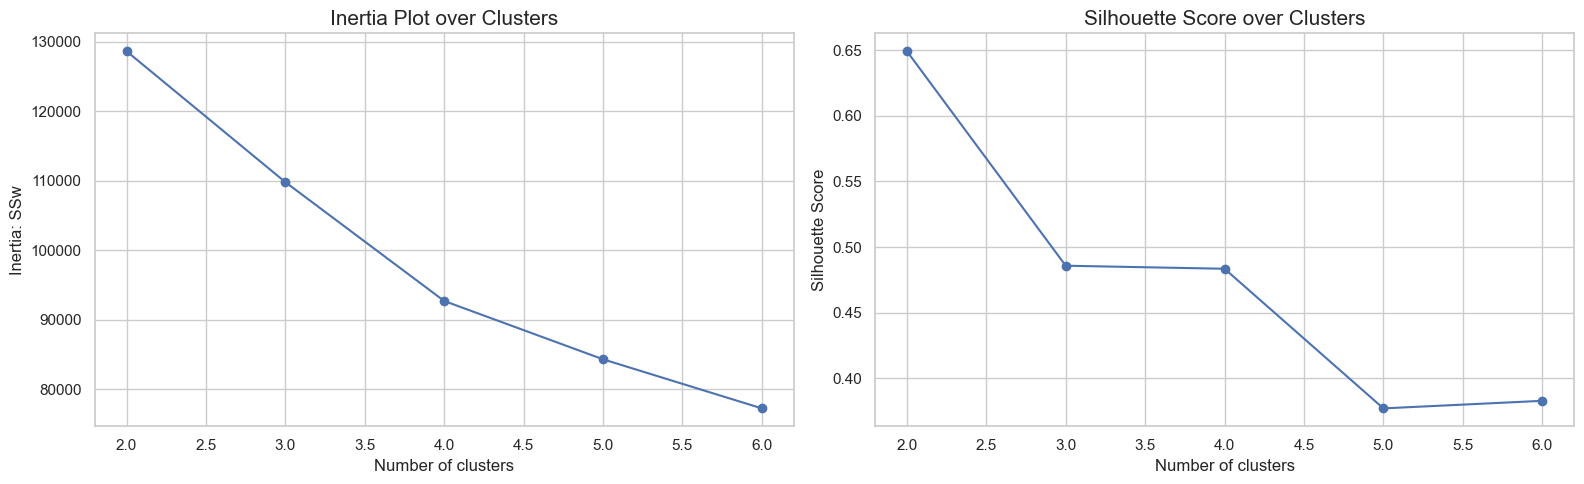

In [321]:
# Define the range of clusters to evaluate
range_clusters = range(2, 7)  # Silhouette score is not defined for 1 cluster

# Initialize lists to store inertia and silhouette scores
inertia = []
silhouette_scores = []

for n_clus in range_clusters:  # iterate over each cluster
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=15)
    cluster_labels = kmclust.fit_predict(df_beh)
    inertia.append(kmclust.inertia_)  # add the inertia of the given cluster solution
    silhouette_avg = silhouette_score(df_beh, cluster_labels)
    silhouette_scores.append(silhouette_avg)  # add the silhouette score of the given cluster solution

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Plot inertia (elbow plot)
ax1.plot(range_clusters, inertia, marker='o')
ax1.set_title("Inertia Plot over Clusters", size=15)
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Inertia: SSw")

# Plot silhouette scores
ax2.plot(range_clusters, silhouette_scores, marker='o')
ax2.set_title("Silhouette Score over Clusters", size=15)
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Silhouette Score")

# Show the plots
plt.tight_layout()
plt.show()

In [322]:
# Better initialization method and provide more n_init
kmclust = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=15)
kmclust.fit(df_beh) #performs clustering ie finds centroids

KMeans(n_clusters=4, n_init=15, random_state=15)

In [323]:
dist_matrix = pd.DataFrame(kmclust.transform(df_beh)) #calculates distance of each sample to respective centroid

In [324]:
km_labels = kmclust.predict(df_beh) #associates cluster index for each sample, based on min distance

In [325]:
# Characterizing the final clusters
df_concat = pd.concat([df_beh, pd.Series(km_labels, name='beh_labels')], axis=1)

# Calculate the mean values for each cluster
df_centroids = df_concat.groupby('beh_labels').mean()

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled


In [326]:
pd.DataFrame(km_labels)[0].value_counts()

0
0    24466
2     4645
3     1896
1      710
Name: count, dtype: int64

In [327]:
df['beh_labels'] = df_concat['beh_labels'] # adds labels to scale df
df['beh_labels'].value_counts()

beh_labels
0    24466
2     4645
3     1896
1      710
Name: count, dtype: int64

**better distributed than preference features**

In [328]:
# using R^2
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss # return sum of sum of squares of each df variable

sst = get_ss(df_beh) # get total sum of squares
ssw_labels = df_concat.groupby(['beh_labels']).apply(get_ss) # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels) # remember: SST = SSW + SSB
r2 = ssb / sst
print('R^2 Score: ', round(r2,3))

R^2 Score:  0.513


In [329]:
silhoutte_score = silhouette_score(df_beh, km_labels, random_state=15)

print('Silhouette Score: ', round(silhoutte_score,3))

Silhouette Score:  0.483


In [330]:
calinski_harabasz = calinski_harabasz_score(df_beh, km_labels)
print('Calinski Harabasz Score: ', round(calinski_harabasz,3))

Calinski Harabasz Score:  11135.398


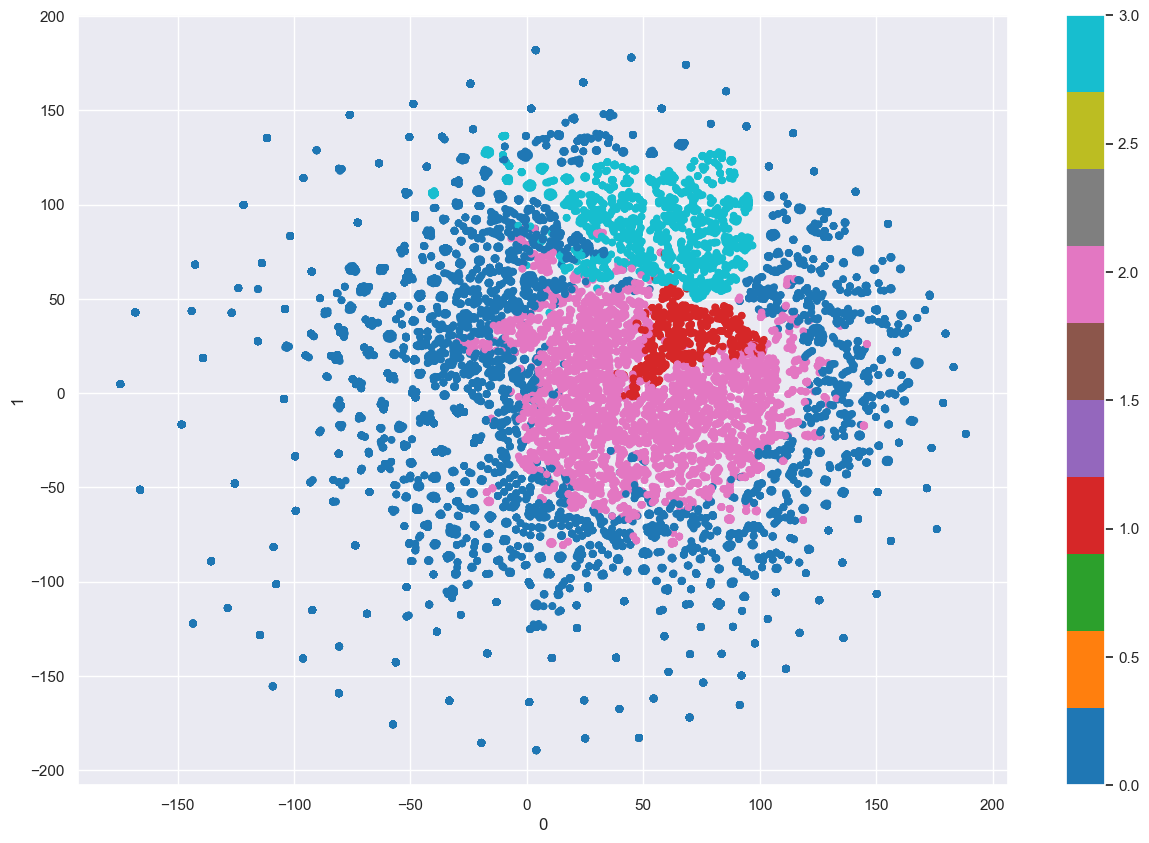

In [375]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42, perplexity=12).fit_transform(df_beh)

# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['beh_labels'], colormap='tab10', figsize=(15,10))
plt.show()

<a class="anchor" id="3rd-bullet">

### Merging using Hierarchical clustering - USED ONE
</a>

In [332]:
df.head()

customer_region  customer_age  vendor_count  product_count  is_chain  \
0             2360     -1.337468     -0.405436      -0.098281 -0.475544   
1             8670     -1.478630     -0.405436      -0.555346 -0.212185   
2             4660      1.485773     -0.771607      -0.555346 -0.212185   
3             4660     -0.208171     -0.405436      -0.402991 -0.475544   
4             4660     -1.055144     -0.405436      -0.098281 -0.738902   

   first_order  last_order last_promo payment_method  CUI_American  ...  \
0    -1.175717   -2.706721   DELIVERY           DIGI     -0.422050  ...   
1    -1.175717   -2.706721   DISCOUNT           DIGI      0.686724  ...   
2    -1.175717   -2.706721   DISCOUNT           CASH      0.373638  ...   
3    -1.175717   -2.663582   DELIVERY           DIGI     -0.422050  ...   
4    -1.175717   -2.663582          -           DIGI      0.838078  ...   

    Weekend  total_spent  total_orders  avg_spending_per_order  \
0  0.429816    -0.209739       -0.4837                0.528655   
1  0.429816    -0.427887       -0.4837               -0.088755   
2  0.429816    -0.653705       -0.4837               -0.727873   
3 -0.148714    -0.149281       -0.4837                0.699767   
4 -0.148714     0.389434       -0.4837                2.224456   

   chain_order_ratio  preferred_cui  preferred_cui_type  value_labels  \
0          -0.327866     CUI_Indian       Asian_Cuisine             2   
1           0.963778   CUI_American     Western_Cuisine             2   
2           0.963778   CUI_American     Western_Cuisine             2   
3          -0.327866     CUI_Indian       Asian_Cuisine             2   
4          -1.619510      CUI_Asian       Asian_Cuisine             1   

   prf_labels  beh_labels  
0           1           0  
1           1           0  
2           1           0  
3           1           0  
4           1           0  

[5 rows x 76 columns]

In [333]:
metric_features = value_perspetive + behaviour_features + preference_features

In [334]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['value_labels', 'prf_labels', 'beh_labels'])\
    [metric_features].mean()
df_centroids

total_spent  avg_spending_per_order  \
value_labels prf_labels beh_labels                                        
0            0          0              0.246050                0.099276   
                        1              0.931307               -0.827418   
                        2              0.667715               -0.331752   
                        3              0.572665                0.030659   
             1          0             -0.387419               -0.314155   
...                                         ...                     ...   
3            3          3              3.326471                1.023052   
             4          0              1.740336                1.240670   
                        1              3.978578               -0.369401   
                        2              2.414522                0.218625   
                        3              2.896776                0.644478   

                                    last_order  Weekdays  is_chain  \
value_labels prf_labels beh_labels                                   
0            0          0             0.545369  0.020711 -0.323203   
                        1             0.885314  3.144824  4.545828   
                        2             0.708474  1.015286  0.591494   
                        3             0.619695  0.474167  0.191083   
             1          0             0.478047 -0.313726 -0.270337   
...                                        ...       ...       ...   
3            3          3             0.756516  1.287347  0.593127   
             4          0             0.658116  0.282599 -0.043635   
                        1             0.936860  4.933537  4.971423   
                        2             0.799858  1.580697  1.391481   
                        3             0.803498  1.425636  0.853692   

                                    HR_breakfast  HR_lunch_dinner  \
value_labels prf_labels beh_labels                                  
0            0          0              -0.161487        -0.089592   
                        1               1.260338         4.199317   
                        2               0.357999         0.520582   
                        3               0.031730        -0.284784   
             1          0              -0.199132        -0.192513   
...                                          ...              ...   
3            3          3               1.210821         0.058942   
             4          0               1.124448        -0.137150   
                        1               5.237852         2.821289   
                        2               2.333560         0.632025   
                        3               1.469961        -0.067471   

                                    HR_afternoon  HR_evening  Western_Cuisine  \
value_labels prf_labels beh_labels                                              
0            0          0               0.518292   -0.273870         2.086774   
                        1               2.068404   -0.137089         2.346698   
                        2               1.453587   -0.319416         2.474891   
                        3              -0.459810    2.799937         2.213223   
             1          0              -0.178966   -0.206068        -0.183209   
...                                          ...         ...              ...   
3            3          3              -0.292096    3.307099         0.336550   
             4          0              -0.561964    0.526033        -0.172581   
                        1               3.196686    0.152292         1.225682   
                        2               0.811228   -0.077881         0.453664   
                        3              -0.396456    3.867349         0.303484   

                                    Asian_Cuisine  Complementary_Cuisine  \
value_labels prf_labels beh_labels                                         
0            0          0               -0.48

In [335]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

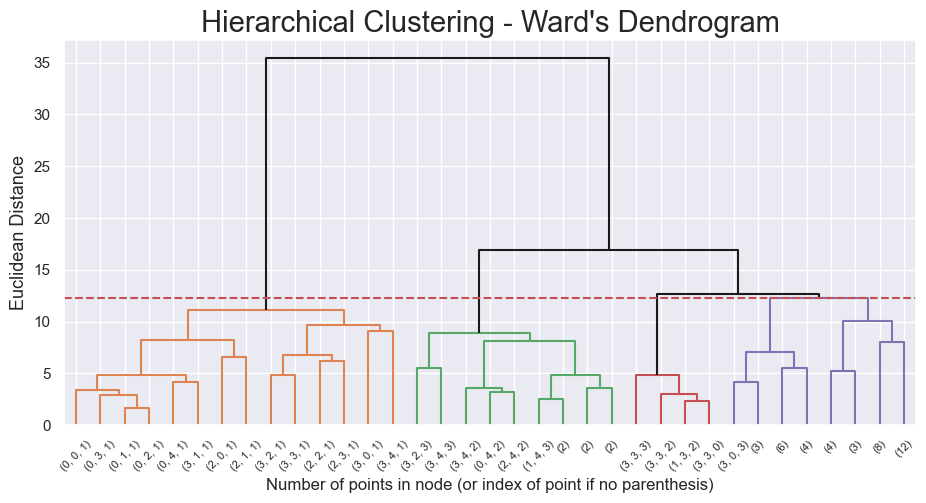

In [336]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned

y_threshold = 12.3

dendrogram(linkage_matrix, 
           truncate_mode='level', 
           labels=df_centroids.index, p=5, 
           color_threshold=y_threshold, 
           above_threshold_color='k')

plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [337]:
#hierarchical_clustering_methods_nclust_analysis(df[metric_features], ["ward"], 7) # 8 minutes to run

In [338]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=5
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

total_spent  avg_spending_per_order  \
value_labels prf_labels beh_labels                                        
0            0          0              0.246050                0.099276   
                        1              0.931307               -0.827418   
                        2              0.667715               -0.331752   
                        3              0.572665                0.030659   
             1          0             -0.387419               -0.314155   
...                                         ...                     ...   
3            3          3              3.326471                1.023052   
             4          0              1.740336                1.240670   
                        1              3.978578               -0.369401   
                        2              2.414522                0.218625   
                        3              2.896776                0.644478   

                                    last_order  Weekdays  is_chain  \
value_labels prf_labels beh_labels                                   
0            0          0             0.545369  0.020711 -0.323203   
                        1             0.885314  3.144824  4.545828   
                        2             0.708474  1.015286  0.591494   
                        3             0.619695  0.474167  0.191083   
             1          0             0.478047 -0.313726 -0.270337   
...                                        ...       ...       ...   
3            3          3             0.756516  1.287347  0.593127   
             4          0             0.658116  0.282599 -0.043635   
                        1             0.936860  4.933537  4.971423   
                        2             0.799858  1.580697  1.391481   
                        3             0.803498  1.425636  0.853692   

                                    HR_breakfast  HR_lunch_dinner  \
value_labels prf_labels beh_labels                                  
0            0          0              -0.161487        -0.089592   
                        1               1.260338         4.199317   
                        2               0.357999         0.520582   
                        3               0.031730        -0.284784   
             1          0              -0.199132        -0.192513   
...                                          ...              ...   
3            3          3               1.210821         0.058942   
             4          0               1.124448        -0.137150   
                        1               5.237852         2.821289   
                        2               2.333560         0.632025   
                        3               1.469961        -0.067471   

                                    HR_afternoon  HR_evening  Western_Cuisine  \
value_labels prf_labels beh_labels                                              
0            0          0               0.518292   -0.273870         2.086774   
                        1               2.068404   -0.137089         2.346698   
                        2               1.453587   -0.319416         2.474891   
                        3              -0.459810    2.799937         2.213223   
             1          0              -0.178966   -0.206068        -0.183209   
...                                          ...         ...              ...   
3            3          3              -0.292096    3.307099         0.336550   
             4          0              -0.561964    0.526033        -0.172581   
                        1               3.196686    0.152292         1.225682   
                        2               0.811228   -0.077881         0.453664   
                        3              -0.396456    3.867349         0.303484   

                                    Asian_Cuisine  Complementary_Cuisine  \
value_labels prf_labels beh_labels                                         
0            0          0               -0.48

In [339]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper

{(0, 0, 0): 1,
 (0, 0, 1): 0,
 (0, 0, 2): 1,
 (0, 0, 3): 4,
 (0, 1, 0): 1,
 (0, 1, 1): 0,
 (0, 1, 2): 1,
 (0, 1, 3): 4,
 (0, 2, 0): 1,
 (0, 2, 1): 0,
 (0, 2, 2): 1,
 (0, 2, 3): 4,
 (0, 3, 0): 1,
 (0, 3, 1): 0,
 (0, 3, 2): 1,
 (0, 3, 3): 4,
 (0, 4, 0): 2,
 (0, 4, 1): 0,
 (0, 4, 2): 2,
 (0, 4, 3): 2,
 (1, 0, 0): 1,
 (1, 0, 3): 4,
 (1, 1, 0): 1,
 (1, 1, 3): 4,
 (1, 2, 0): 1,
 (1, 2, 2): 1,
 (1, 2, 3): 4,
 (1, 3, 0): 1,
 (1, 3, 2): 3,
 (1, 3, 3): 4,
 (1, 4, 0): 2,
 (1, 4, 3): 2,
 (2, 0, 0): 1,
 (2, 0, 1): 0,
 (2, 0, 2): 1,
 (2, 0, 3): 4,
 (2, 1, 0): 1,
 (2, 1, 1): 0,
 (2, 1, 2): 1,
 (2, 1, 3): 4,
 (2, 2, 0): 1,
 (2, 2, 1): 0,
 (2, 2, 2): 1,
 (2, 2, 3): 4,
 (2, 3, 0): 1,
 (2, 3, 1): 0,
 (2, 3, 2): 1,
 (2, 3, 3): 4,
 (2, 4, 0): 2,
 (2, 4, 2): 2,
 (2, 4, 3): 2,
 (3, 0, 0): 1,
 (3, 0, 1): 0,
 (3, 0, 2): 1,
 (3, 0, 3): 4,
 (3, 1, 0): 1,
 (3, 1, 1): 0,
 (3, 1, 2): 1,
 (3, 1, 3): 4,
 (3, 2, 0): 1,
 (3, 2, 1): 0,
 (3, 2, 2): 1,
 (3, 2, 3): 2,
 (3, 3, 0): 3,
 (3, 3, 1): 0,
 (3, 3, 2): 3,
 (3, 3, 3)

In [340]:
df_hc = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_hc['merged_labels'] = df_hc.apply(
    lambda row: cluster_mapper[
        (row['value_labels'], row['prf_labels'], row['beh_labels'])
    ], axis=1
)

df_hc

customer_region  customer_age  vendor_count  product_count  is_chain  \
0                 2360     -1.337468     -0.405436      -0.098281 -0.475544   
1                 8670     -1.478630     -0.405436      -0.555346 -0.212185   
2                 4660      1.485773     -0.771607      -0.555346 -0.212185   
3                 4660     -0.208171     -0.405436      -0.402991 -0.475544   
4                 4660     -1.055144     -0.405436      -0.098281 -0.738902   
...                ...           ...           ...            ...       ...   
31712             8670      0.356477     -0.771607      -0.707701 -0.475544   
31713             8670     -0.208171     -0.771607      -0.707701 -0.738902   
31714             8670     -0.490496     -0.771607      -0.707701 -0.475544   
31715             8670      0.921125     -0.771607      -0.707701 -0.738902   
31716             4660      0.356477     -0.771607      -0.707701 -0.738902   

       first_order  last_order last_promo payment_method  CUI_American  ...  \
0        -1.175717   -2.706721   DELIVERY           DIGI     -0.422050  ...   
1        -1.175717   -2.706721   DISCOUNT           DIGI      0.686724  ...   
2        -1.175717   -2.706721   DISCOUNT           CASH      0.373638  ...   
3        -1.175717   -2.663582   DELIVERY           DIGI     -0.422050  ...   
4        -1.175717   -2.663582          -           DIGI      0.838078  ...   
...            ...         ...        ...            ...           ...  ...   
31712    -1.175717   -2.749860    FREEBIE           DIGI     -0.422050  ...   
31713    -1.175717   -2.749860   DELIVERY           DIGI      1.138191  ...   
31714    -1.175717   -2.749860          -           DIGI     -0.422050  ...   
31715    -1.175717   -2.749860   DISCOUNT           DIGI     -0.422050  ...   
31716    -1.175717   -2.749860          -           CASH     -0.422050  ...   

       total_spent  total_orders  avg_spending_per_order  chain_order_ratio  \
0        -0.209739      -0.48370                0.528655          -0.327866   
1        -0.427887      -0.48370               -0.088755           0.963778   
2        -0.653705      -0.48370               -0.727873           0.963778   
3        -0.149281      -0.48370                0.699767          -0.327866   
4         0.389434      -0.48370                2.224456          -1.619510   
...            ...           ...                     ...                ...   
31712    -0.454282      -0.68905                0.988360           0.963778   
31713    -0.454282      -0.68905                0.988360          -1.619510   
31714    -0.459921      -0.68905                0.956436           0.963778   
31715    -0.589863      -0.68905                0.220908          -1.619510   
31716    -0.682807      -0.68905               -0.305200          -1.619510   

       preferred_cui     preferred_cui_type  value_labels  prf_labels  \
0         CUI_Indian          Asian_Cuisine             2           1   
1       CUI_American        Western_Cuisine             2           1   
2       CUI_American        Western_Cuisine             2           1   
3         CUI_Indian          Asian_Cuisine             2           1   
4          CUI_Asian          Asian_Cuisine             1           1   
...              ...                    ...           ...         ...   
31712  CUI_Beverages  Complementary_Cuisine             2           1   
31713   CUI_American        Western_Cuisine             2           1   
31714   CUI_Desserts  Complementary_Cuisine             2           1   
31715      CUI_Asian          Asian_Cuisine             2           1   
31716    CUI_Italian        Western_Cuisine             2           1   

       beh_labels  merged_labels  
0               0              1  
1               0              1  
2               0              1  
3               0              1  
4               0              1  
...           ...            ...  
31712           0              1  
317

In [341]:
df_hc['merged_labels'].value_counts()

merged_labels
1    28275
2     1219
4     1119
0      710
3      394
Name: count, dtype: int64

In [342]:
# Calculate the mean of each group
df_centroids = df_hc[metric_features + ['merged_labels']].groupby('merged_labels').mean(numeric_only=True)

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled

In [343]:
df_hc.head(1)

customer_region  customer_age  vendor_count  product_count  is_chain  \
0             2360     -1.337468     -0.405436      -0.098281 -0.475544   

   first_order  last_order last_promo payment_method  CUI_American  ...  \
0    -1.175717   -2.706721   DELIVERY           DIGI      -0.42205  ...   

   total_spent  total_orders  avg_spending_per_order  chain_order_ratio  \
0    -0.209739       -0.4837                0.528655          -0.327866   

   preferred_cui  preferred_cui_type  value_labels  prf_labels  beh_labels  \
0     CUI_Indian       Asian_Cuisine             2           1           0   

   merged_labels  
0              1  

[1 rows x 77 columns]

<div class="alert alert-block alert-success">

<a class="anchor" id="1st-bullet">    </a>
## 3. Cluster Analysis & Profiling with categorical features
    

    
</div>

<a class="anchor" id="3rd-bullet">

### Cluster Analysis:
</a>

In [282]:
def cluster_profiles(df, label_columns, figsize, 
                     cmap="tab10",
                     compare_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    
    if compare_titles == None:
        compare_titles = [""]*len(label_columns)
        
    fig, axes = plt.subplots(nrows=len(label_columns), 
                             ncols=2, 
                             figsize=figsize, 
                             constrained_layout=True,
                             squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compare_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, 
                                            label, 
                                            color = sns.color_palette(cmap),
                                            ax=ax[0])



        sns.barplot(x=label, 
                    hue=label,
                    y="counts", 
                    data=counts, 
                    ax=ax[1], 
                    palette=sns.color_palette(cmap),
                    legend=False
                    )

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), 
                              rotation=40,
                              ha='right'
                              )
        
        ax[0].legend(handles, cluster_labels,
                     loc='center left', bbox_to_anchor=(1, 0.5), title=label
                     ) # Adaptable to number of clusters
        
        ax[1].set_xticks([i for i in range(len(handles))])
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
        
        
    
    # plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profiling", fontsize=23)
    plt.show()

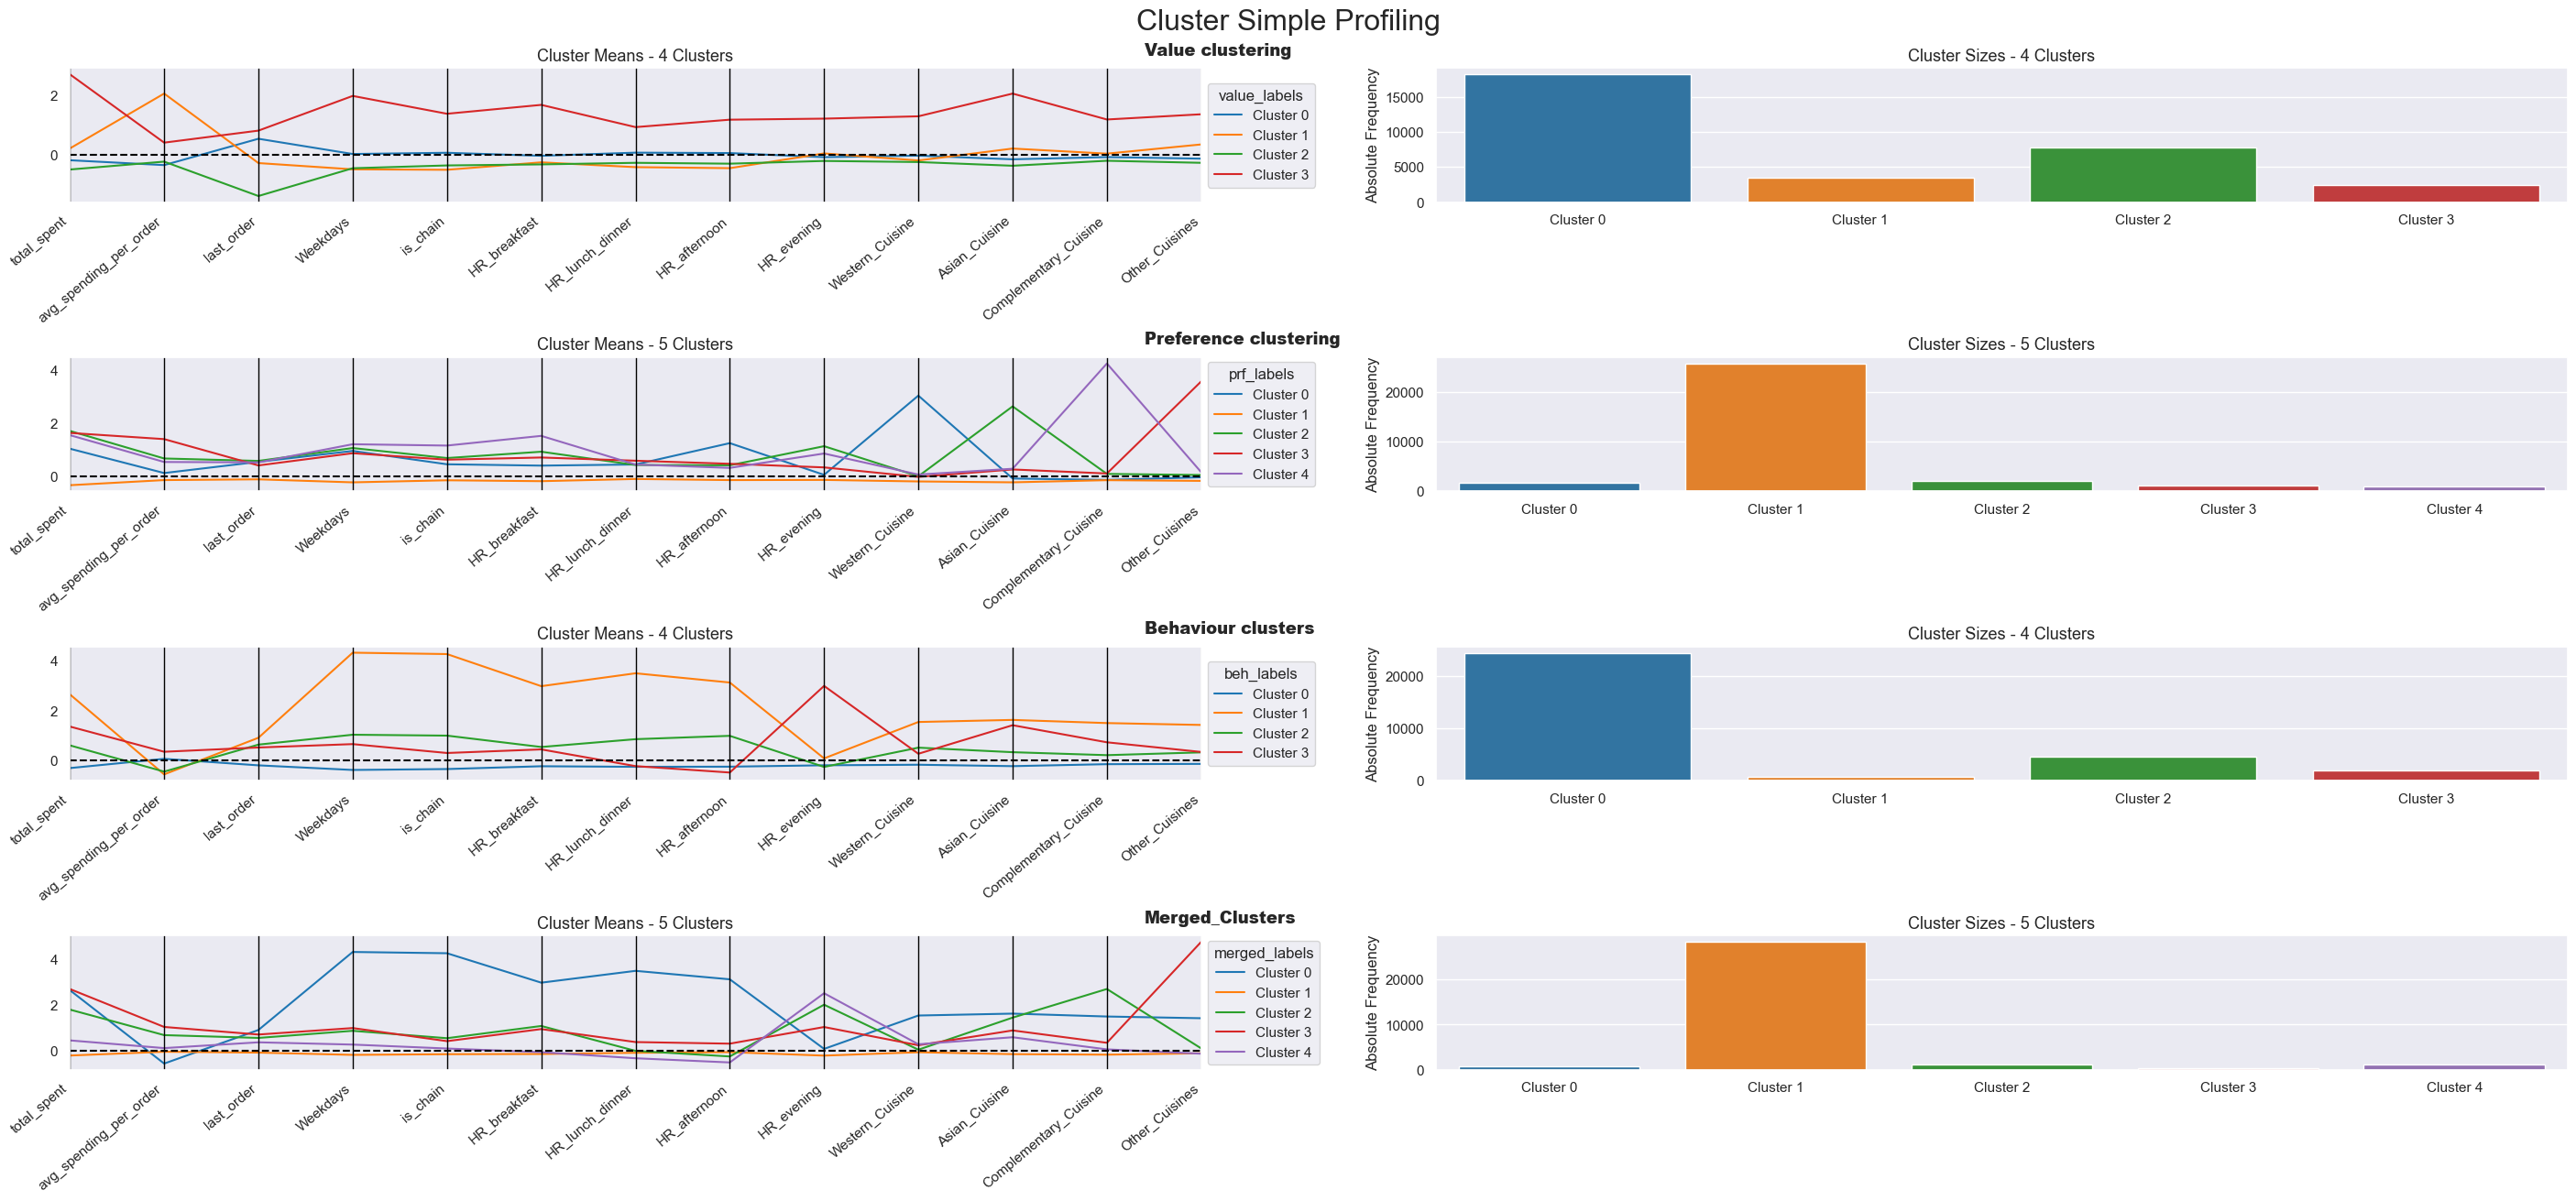

In [283]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df_hc[metric_features + ['value_labels', 'prf_labels', 'beh_labels', 'merged_labels']], 
    label_columns = ['value_labels', 'prf_labels', 'beh_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compare_titles = ["Value clustering", "Preference clustering", "Behaviour clusters", "Merged_Clusters"]
)

<a class="anchor" id="3rd-bullet">

### Profiling - Association categorical labels
</a>

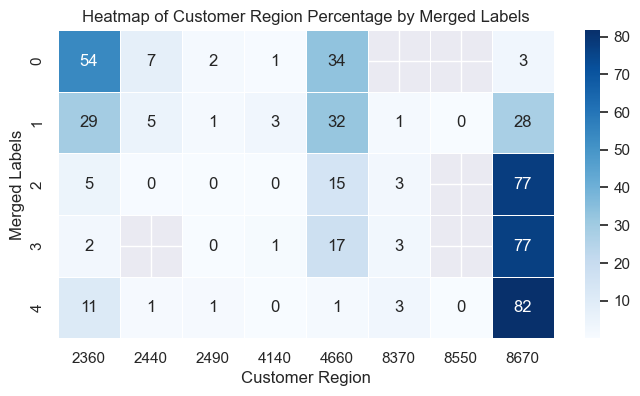

In [205]:
# Group by merged_labels and customer_region
df_cl_region = df_hc.groupby(['merged_labels', 'customer_region'])['customer_region'].size().unstack()

# Calculate the percentage distribution
df_cl_region_pct = df_cl_region.copy()
for i in df_hc['customer_region'].unique():
    df_cl_region_pct[i] = 100 * df_cl_region_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_cl_region_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of Customer Region Percentage by Merged Labels')
plt.xlabel('Customer Region')
plt.ylabel('Merged Labels')
plt.show()


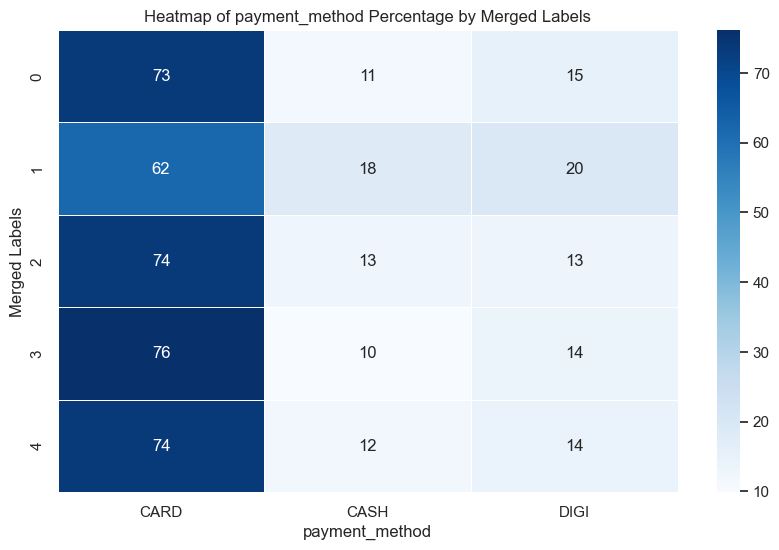

In [206]:
# Group by merged_labels and payment_method
df_cl_payment = df_hc.groupby(['merged_labels', 'payment_method'])['payment_method'].size().unstack()

# Calculate the percentage distribution
df_cl_payment_pct = df_cl_payment.copy()
for i in df_hc['payment_method'].unique():
    df_cl_payment_pct[i] = 100 * df_cl_payment_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_cl_payment_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of payment_method Percentage by Merged Labels')
plt.xlabel('payment_method')
plt.ylabel('Merged Labels')
plt.show()

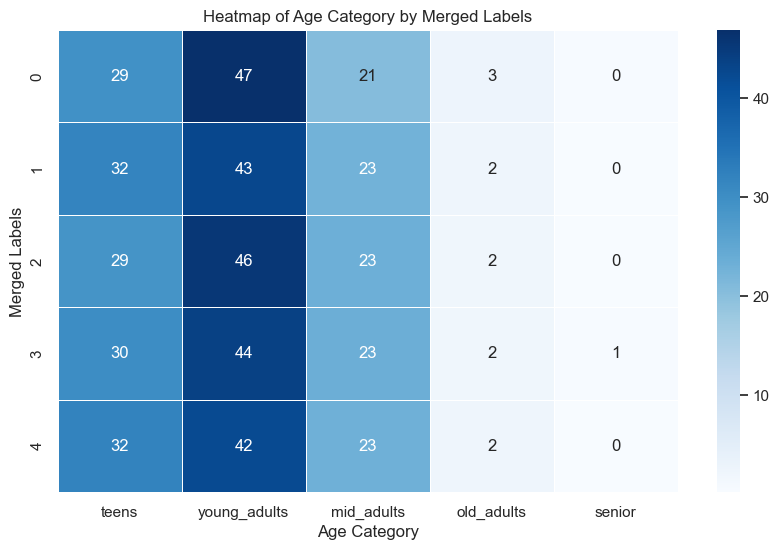

In [207]:
# Group by merged_labels and age_category
# Define the order of age categories from youngest to oldest
age_order = ['teens', 'young_adults', 'mid_adults', 'old_adults', 'senior']
df_hc['age_category'] = pd.Categorical(df_hc['age_category'], categories=age_order, ordered=True)

df_cl_age = df_hc.groupby(['merged_labels', 'age_category'])['age_category'].size().unstack()

# Reorder the columns based on the defined age order
df_cl_age = df_cl_age[age_order]

# Calculate the percentage distribution
df_cl_age_pct = df_cl_age.copy()
for i in df_hc['age_category'].unique():
    df_cl_age_pct[i] = 100 * df_cl_age_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_cl_age_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of Age Category by Merged Labels')
plt.xlabel('Age Category')
plt.ylabel('Merged Labels')
plt.show()

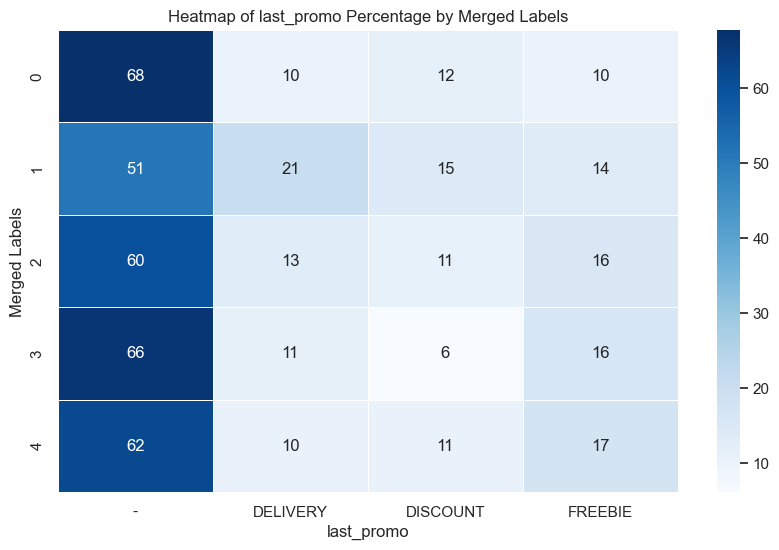

In [208]:
# Group by merged_labels and last_promo
df_cl_promo = df_hc.groupby(['merged_labels', 'last_promo'])['last_promo'].size().unstack()

# Calculate the percentage distribution
df_cl_promo_pct = df_cl_promo.copy()
for i in df_hc['last_promo'].unique():
    df_cl_promo_pct[i] = 100 * df_cl_promo_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_cl_promo_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of last_promo Percentage by Merged Labels')
plt.xlabel('last_promo')
plt.ylabel('Merged Labels')
plt.show()

In [209]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [217]:
calinski_harabasz_score(df_hc[metric_features], df_hc['merged_labels'])

3186.4358677467053

In [218]:
get_r2_score(df_hc[metric_features + ['merged_labels']],'merged_labels')

0.286762789566143

In [219]:
silhouette_score(df_hc[metric_features],df_hc['merged_labels'], random_state=15)

0.17842398114017238

In [213]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(df_hc[metric_features + ['merged_labels']], 'merged_labels').drop('merged_labels')

total_spent               0.417302
avg_spending_per_order    0.040487
last_order                0.047326
Weekdays                  0.489558
is_chain                  0.440125
HR_breakfast              0.272049
HR_lunch_dinner           0.285285
HR_afternoon              0.234007
HR_evening                0.431619
Western_Cuisine           0.060301
Asian_Cuisine             0.181035
Complementary_Cuisine     0.357270
Other_Cuisines            0.338074
dtype: float64

In [214]:
# Preparing the data
X = df_hc[metric_features]
y = df_hc.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=5)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 97.97% of the customers correctly


In [215]:
pd.Series(dt.feature_importances_, index=X_train.columns).to_frame(name='Importance')

Importance
total_spent               0.101388
avg_spending_per_order    0.008910
last_order                0.000000
Weekdays                  0.170652
is_chain                  0.029046
HR_breakfast              0.000000
HR_lunch_dinner           0.001943
HR_afternoon              0.000000
HR_evening                0.400440
Western_Cuisine           0.007632
Asian_Cuisine             0.003675
Complementary_Cuisine     0.227806
Other_Cuisines            0.048508

<a class="anchor" id="3rd-bullet">

### TSNE ALL metric features
</a>

In [74]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42, perplexity=12).fit_transform(df_hc[metric_features])


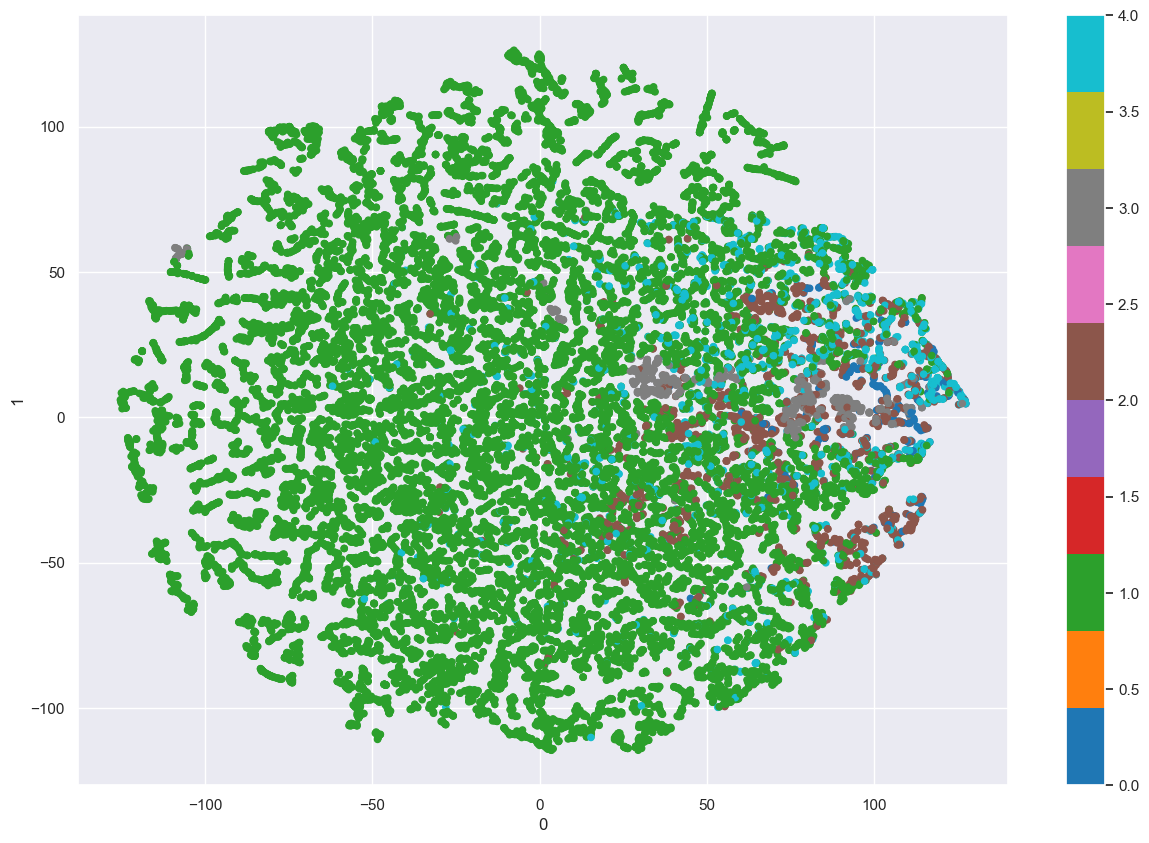

In [75]:
# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_hc['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()

### Final reverse scale

In [ ]:
# To revert back to original values
original_values = ss_scaler.inverse_transform(df_hc[columns_to_scale])

# Update the df with the original values
df_hc[columns_to_scale] = original_values

# Calculate the mean of each group
df_centroids = df_hc[metric_features + ['merged_labels']].groupby('merged_labels').mean(numeric_only=True)

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled

In [220]:
df_concat = df_hc.set_index("merged_labels")
df_concat.head(1)

customer_region  customer_age  vendor_count  product_count  \
merged_labels                                                               
1                         2360          18.0           2.0            5.0   

               is_chain  first_order  last_order last_promo payment_method  \
merged_labels                                                                
1                   1.0          0.0         1.0   DELIVERY           DIGI   

               CUI_American  ...  Weekend  total_spent  total_orders  \
merged_labels                ...                                       
1                       0.0  ...      2.0        28.88           2.0   

               avg_spending_per_order  chain_order_ratio  preferred_cui  \
merged_labels                                                             
1                               14.44                0.5     CUI_Indian   

               preferred_cui_type  value_labels  prf_labels  beh_labels  
merged_labels                                                            
1                   Asian_Cuisine             2           1           0  

[1 rows x 76 columns]

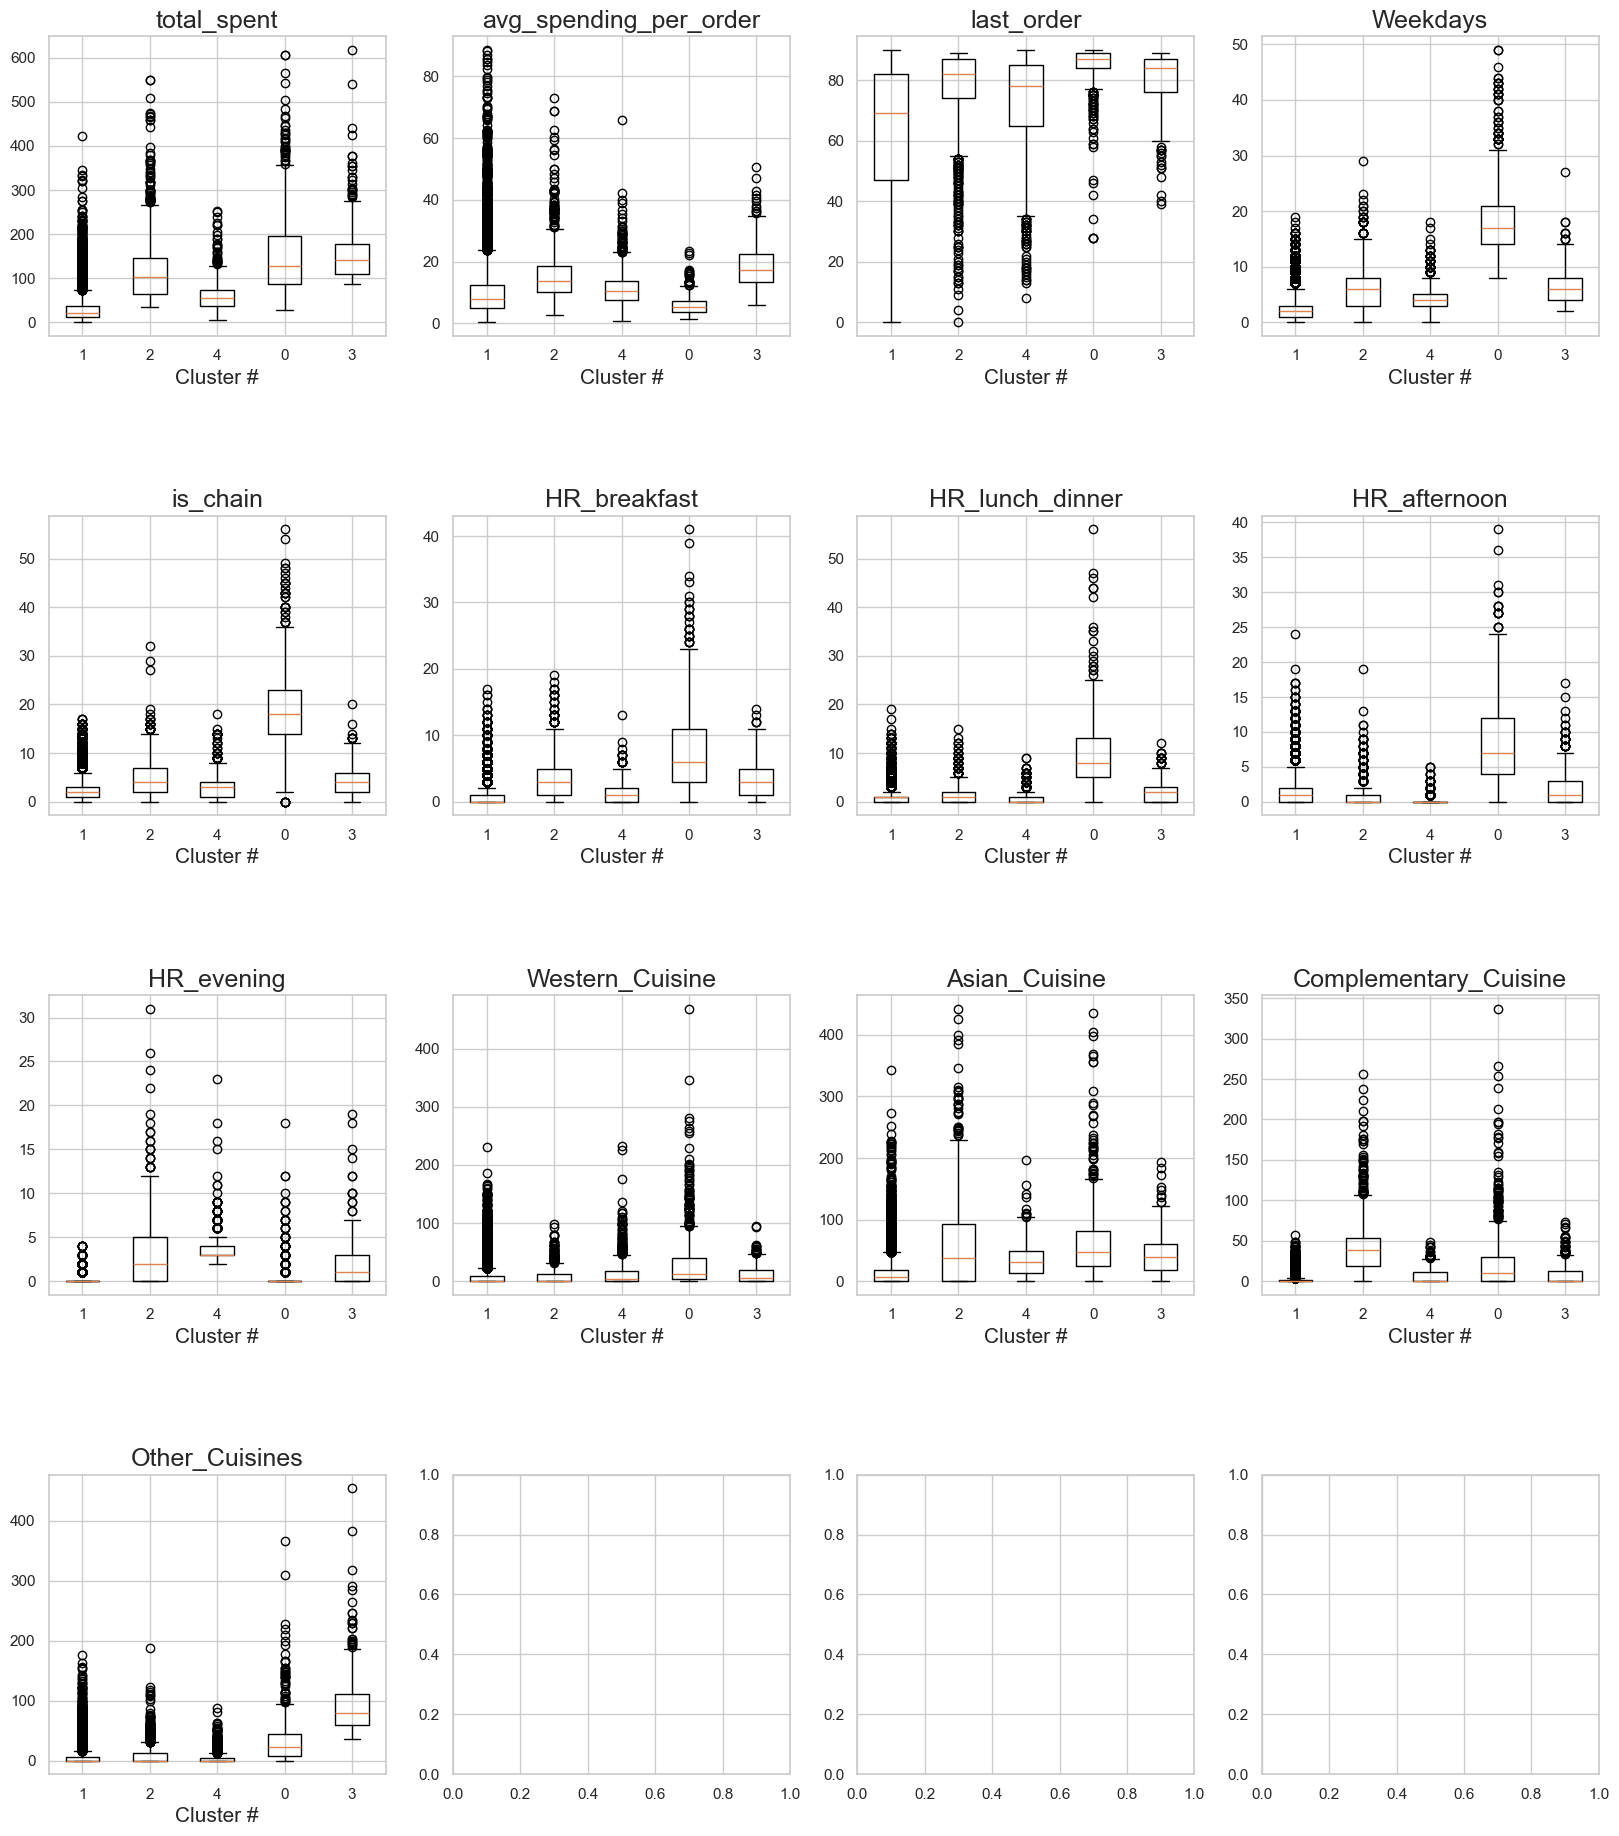

In [221]:
# Select the columns for plotting
df_plots = df_hc[metric_features]

# Set the style for seaborn
sns.set()
sns.set_style(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(4, 4, figsize=(20, 22))

# Iterate over each variable and create boxplots
for ax, variable in zip(axes.flatten(), df_plots.columns):
    my_dict = {str(label): df_concat.loc[label, variable].values for label in df_concat.index.unique()}
    ax.boxplot(my_dict.values())
    ax.set_title(variable, fontsize=18)
    ax.set_xlabel('Cluster #', fontsize=15)
    ax.set_xticklabels(my_dict.keys())

# Adjust the layout
plt.subplots_adjust(hspace=0.6, top=0.90)

# Show the plot
plt.show()


<div class="alert alert-block alert-success">

<a class="anchor" id="1st-bullet">    </a>
## 4. Hierarchical Clustering from the beggining
    


</div>

<a class="anchor" id="3rd-bullet">

### Value perspetive
</a>

In [344]:
df_value_hc = df_value.copy()

In [345]:
df_value_hc.head()

total_spent  avg_spending_per_order  last_order
0    -0.209739                0.528655   -2.706721
1    -0.427887               -0.088755   -2.706721
2    -0.653705               -0.727873   -2.706721
3    -0.149281                0.699767   -2.663582
4     0.389434                2.224456   -2.663582

In [346]:
#hierarchical_clustering_methods_nclust_analysis(df_value_hc, ["ward"], 6)

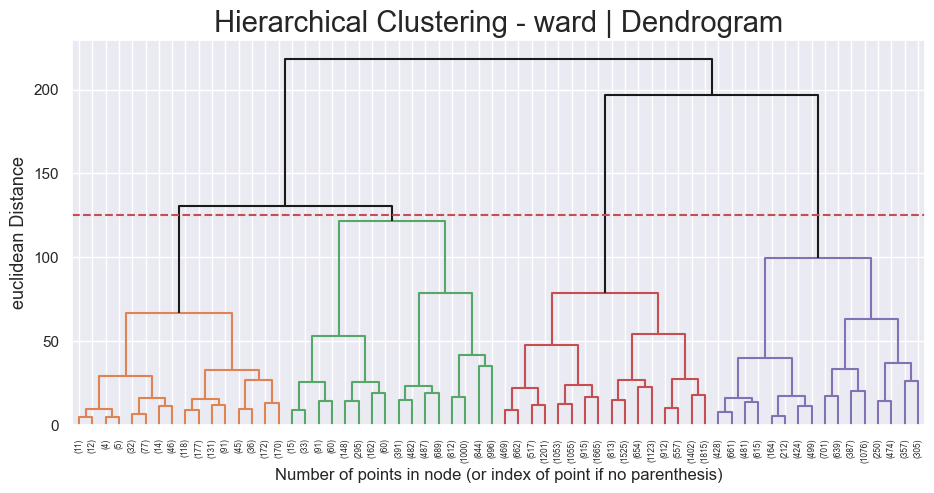

In [347]:
plot_dendrogram(dataframe=df_value_hc, y_threshold= 125, linkage="ward", metric='euclidean')

Optimal Number of Clusters = 4

In [348]:
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=4)
df_value_hc['value_labels'] =  hclust.fit_predict(df_value_hc)
df_centroids = df_value_hc.groupby('value_labels').mean()

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled

In [349]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_value_hc)  # get total sum of squares
ssw_labels = df_value_hc[value_perspetive + ["value_labels"]].groupby(by='value_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.632618672777253

<a class="anchor" id="3rd-bullet">

### Preference Based Features
</a>


In [350]:
df_prf_hc = df_prf.copy()

In [351]:
#hierarchical_clustering_methods_nclust_analysis(df_prf_hc, ["ward"], 6)

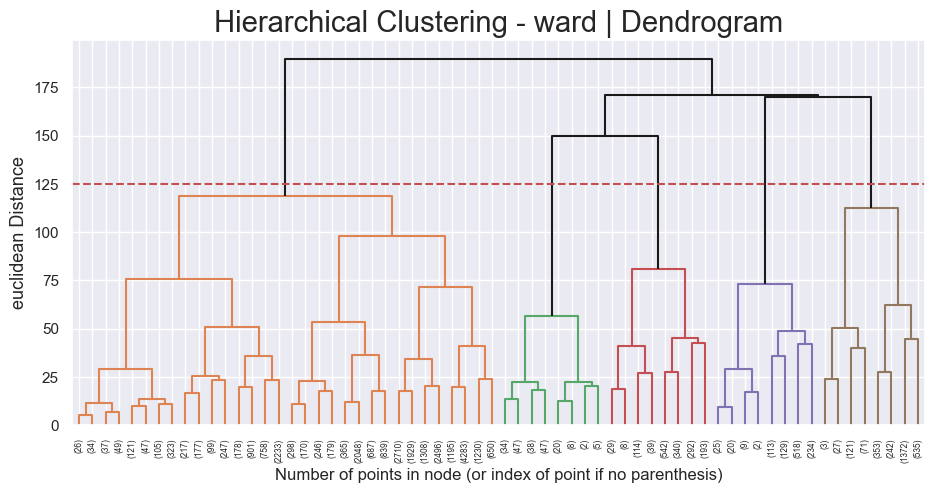

In [352]:
plot_dendrogram(dataframe=df_prf_hc, y_threshold= 125, linkage="ward", metric='euclidean')

In [353]:
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
df_prf_hc['preference_labels'] =  hclust.fit_predict(df_prf_hc)
df_centroids = df_prf_hc.groupby('preference_labels').mean()

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled

In [354]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_prf_hc)  # get total sum of squares
ssw_labels = df_prf_hc[preference_features + ["preference_labels"]].groupby(by='preference_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.537121636306177

<a class="anchor" id="3rd-bullet">

### Behaviour Based Features
</a>


In [355]:
df_beh_hc = df_beh.copy()

In [356]:
#hierarchical_clustering_methods_nclust_analysis(df_beh_hc, ["ward"], 6)

- The ward linkage is the one that performed better getting higher values in R^2 and the distance that will be used is euclidean

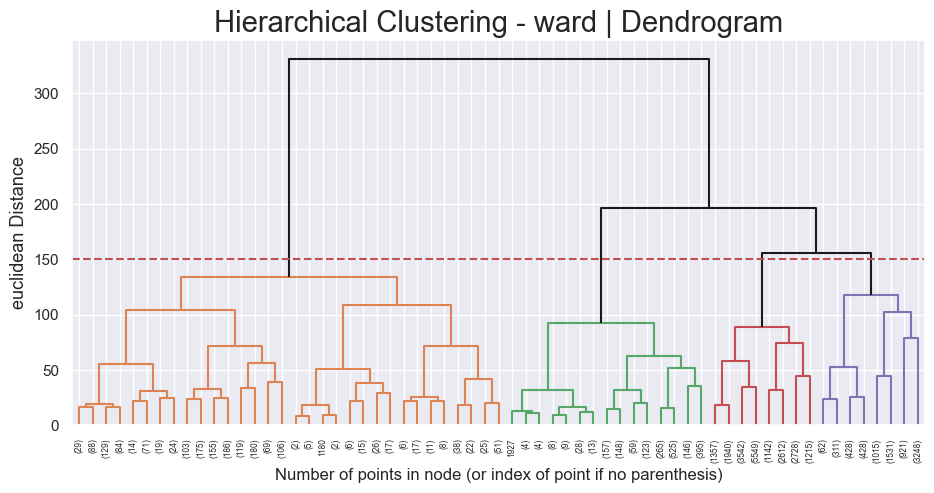

In [357]:
plot_dendrogram(dataframe=df_beh_hc, y_threshold=150, linkage="ward", metric='euclidean')

In [358]:
hclust_beh = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
df_beh_hc['behaviour_labels'] =  hclust_beh.fit_predict(df_beh_hc)
df_centroids = df_beh_hc.groupby('behaviour_labels').mean()

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled

In [359]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_beh_hc)  # get total sum of squares
ssw_labels = df_beh_hc[behaviour_features + ["behaviour_labels"]].groupby(by='behaviour_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.6158453333660759

<a class="anchor" id="3rd-bullet">

### MERGED HC Perspetives
</a>

In [360]:
df["values_labels"] = df_value_hc["value_labels"]
df["preference_labels"] = df_prf_hc["preference_labels"]
df["behaviour_labels"] = df_beh_hc["behaviour_labels"]

In [361]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['values_labels', 'preference_labels', 'behaviour_labels'])\
    [metric_features].mean()
df_centroids

total_spent  \
values_labels preference_labels behaviour_labels                
0             0                 0                    0.707795   
                                1                    1.503338   
                                2                    0.807994   
                                3                    0.040000   
                                4                    1.139345   
...                                                       ...   
3             4                 0                    2.790471   
                                1                    5.410796   
                                2                    3.436471   
                                3                    2.429241   
                                4                    4.154132   

                                                  avg_spending_per_order  \
values_labels preference_labels behaviour_labels                           
0             0                 0                              -0.027696   
                                1                              -0.818427   
                                2                               0.293775   
                                3                               1.331419   
                                4                              -0.607370   
...                                                                  ...   
3             4                 0                               0.758993   
                                1                              -0.105752   
                                2                               0.908722   
                                3                               1.371740   
                                4                               0.051461   

                                                  last_order  Weekdays  \
values_labels preference_labels behaviour_labels                         
0             0                 0                   0.786272  0.678588   
                                1                   0.909106  4.901860   
                                2                   0.702384  0.396409   
                                3                   0.532076 -0.422769   
                                4                   0.878361  2.554314   
...                                                      ...       ...   
3             4                 0                   0.729295  1.286775   
                                1                   0.956853  5.367106   
                                2                   0.810761  1.568727   
                                3                   0.960089  0.664352   
                                4                   0.836554  3.103748   

                                                  is_chain  HR_breakfast  \
values_labels preference_labels behaviour_labels                           
0             0                 0                 0.467796      0.767331   
                                1                 5.569735      4.281363   
                                2                 0.216635      0.302850   
                                3                -0.463225     -0.164709   
                                4                 2.950177      1.119309   
...                                                    ...           ...   
3             4                 0                 1.104608      2.750495   
                                1                 5.160332      7.753717   
                                2                 1.151878      1.314979   
                                3                -0.080506      0.827961   
                                4                 2.876294      2.575719   

                                                  HR_lunch_dinner  \
values_labels preference_labels behaviour_labels                    
0             0                 0                        0.202462   
                                1                       

In [362]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

In [363]:
#hierarchical_clustering_methods_nclust_analysis(df[metric_features], ["ward"], 7)

In [364]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=5
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

total_spent  \
values_labels preference_labels behaviour_labels                
0             0                 0                    0.707795   
                                1                    1.503338   
                                2                    0.807994   
                                3                    0.040000   
                                4                    1.139345   
...                                                       ...   
3             4                 0                    2.790471   
                                1                    5.410796   
                                2                    3.436471   
                                3                    2.429241   
                                4                    4.154132   

                                                  avg_spending_per_order  \
values_labels preference_labels behaviour_labels                           
0             0                 0                              -0.027696   
                                1                              -0.818427   
                                2                               0.293775   
                                3                               1.331419   
                                4                              -0.607370   
...                                                                  ...   
3             4                 0                               0.758993   
                                1                              -0.105752   
                                2                               0.908722   
                                3                               1.371740   
                                4                               0.051461   

                                                  last_order  Weekdays  \
values_labels preference_labels behaviour_labels                         
0             0                 0                   0.786272  0.678588   
                                1                   0.909106  4.901860   
                                2                   0.702384  0.396409   
                                3                   0.532076 -0.422769   
                                4                   0.878361  2.554314   
...                                                      ...       ...   
3             4                 0                   0.729295  1.286775   
                                1                   0.956853  5.367106   
                                2                   0.810761  1.568727   
                                3                   0.960089  0.664352   
                                4                   0.836554  3.103748   

                                                  is_chain  HR_breakfast  \
values_labels preference_labels behaviour_labels                           
0             0                 0                 0.467796      0.767331   
                                1                 5.569735      4.281363   
                                2                 0.216635      0.302850   
                                3                -0.463225     -0.164709   
                                4                 2.950177      1.119309   
...                                                    ...           ...   
3             4                 0                 1.104608      2.750495   
                                1                 5.160332      7.753717   
                                2                 1.151878      1.314979   
                                3                -0.080506      0.827961   
                                4                 2.876294      2.575719   

                                                  HR_lunch_dinner  \
values_labels preference_labels behaviour_labels                    
0             0                 0                        0.202462   
                                1                       

In [365]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper

{(0, 0, 0): 0,
 (0, 0, 1): 1,
 (0, 0, 2): 0,
 (0, 0, 3): 0,
 (0, 0, 4): 3,
 (0, 1, 0): 0,
 (0, 1, 1): 1,
 (0, 1, 2): 0,
 (0, 1, 3): 0,
 (0, 1, 4): 3,
 (0, 2, 0): 0,
 (0, 2, 1): 1,
 (0, 2, 2): 0,
 (0, 2, 3): 0,
 (0, 2, 4): 3,
 (0, 3, 0): 0,
 (0, 3, 1): 1,
 (0, 3, 2): 0,
 (0, 3, 3): 0,
 (0, 3, 4): 3,
 (0, 4, 0): 2,
 (0, 4, 1): 4,
 (0, 4, 2): 2,
 (0, 4, 3): 2,
 (0, 4, 4): 1,
 (1, 0, 0): 0,
 (1, 0, 2): 0,
 (1, 0, 3): 0,
 (1, 0, 4): 3,
 (1, 1, 0): 0,
 (1, 1, 2): 0,
 (1, 1, 3): 0,
 (1, 1, 4): 3,
 (1, 2, 0): 0,
 (1, 2, 2): 0,
 (1, 2, 3): 0,
 (1, 3, 0): 0,
 (1, 3, 2): 0,
 (1, 3, 3): 0,
 (1, 3, 4): 3,
 (1, 4, 3): 2,
 (2, 0, 0): 0,
 (2, 0, 1): 1,
 (2, 0, 2): 0,
 (2, 0, 3): 0,
 (2, 0, 4): 3,
 (2, 1, 0): 0,
 (2, 1, 2): 0,
 (2, 1, 3): 0,
 (2, 1, 4): 3,
 (2, 2, 0): 0,
 (2, 2, 2): 0,
 (2, 2, 3): 0,
 (2, 2, 4): 3,
 (2, 3, 0): 0,
 (2, 3, 2): 0,
 (2, 3, 3): 0,
 (2, 3, 4): 3,
 (3, 0, 0): 0,
 (3, 0, 1): 1,
 (3, 0, 2): 0,
 (3, 0, 3): 0,
 (3, 0, 4): 1,
 (3, 1, 0): 0,
 (3, 1, 1): 1,
 (3, 1, 2): 0,
 (3, 1, 3)

In [366]:
df_hc = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_hc['merged_labels'] = df_hc.apply(
    lambda row: cluster_mapper[
        (row['values_labels'], row['preference_labels'], row['behaviour_labels'])
    ], axis=1
)

df_hc

customer_region  customer_age  vendor_count  product_count  is_chain  \
0                 2360     -1.337468     -0.405436      -0.098281 -0.475544   
1                 8670     -1.478630     -0.405436      -0.555346 -0.212185   
2                 4660      1.485773     -0.771607      -0.555346 -0.212185   
3                 4660     -0.208171     -0.405436      -0.402991 -0.475544   
4                 4660     -1.055144     -0.405436      -0.098281 -0.738902   
...                ...           ...           ...            ...       ...   
31712             8670      0.356477     -0.771607      -0.707701 -0.475544   
31713             8670     -0.208171     -0.771607      -0.707701 -0.738902   
31714             8670     -0.490496     -0.771607      -0.707701 -0.475544   
31715             8670      0.921125     -0.771607      -0.707701 -0.738902   
31716             4660      0.356477     -0.771607      -0.707701 -0.738902   

       first_order  last_order last_promo payment_method  CUI_American  ...  \
0        -1.175717   -2.706721   DELIVERY           DIGI     -0.422050  ...   
1        -1.175717   -2.706721   DISCOUNT           DIGI      0.686724  ...   
2        -1.175717   -2.706721   DISCOUNT           CASH      0.373638  ...   
3        -1.175717   -2.663582   DELIVERY           DIGI     -0.422050  ...   
4        -1.175717   -2.663582          -           DIGI      0.838078  ...   
...            ...         ...        ...            ...           ...  ...   
31712    -1.175717   -2.749860    FREEBIE           DIGI     -0.422050  ...   
31713    -1.175717   -2.749860   DELIVERY           DIGI      1.138191  ...   
31714    -1.175717   -2.749860          -           DIGI     -0.422050  ...   
31715    -1.175717   -2.749860   DISCOUNT           DIGI     -0.422050  ...   
31716    -1.175717   -2.749860          -           CASH     -0.422050  ...   

       chain_order_ratio  preferred_cui     preferred_cui_type  value_labels  \
0              -0.327866     CUI_Indian          Asian_Cuisine             2   
1               0.963778   CUI_American        Western_Cuisine             2   
2               0.963778   CUI_American        Western_Cuisine             2   
3              -0.327866     CUI_Indian          Asian_Cuisine             2   
4              -1.619510      CUI_Asian          Asian_Cuisine             1   
...                  ...            ...                    ...           ...   
31712           0.963778  CUI_Beverages  Complementary_Cuisine             2   
31713          -1.619510   CUI_American        Western_Cuisine             2   
31714           0.963778   CUI_Desserts  Complementary_Cuisine             2   
31715          -1.619510      CUI_Asian          Asian_Cuisine             2   
31716          -1.619510    CUI_Italian        Western_Cuisine             2   

       prf_labels  beh_labels  values_labels  preference_labels  \
0               1           0              1                  0   
1               1           0              1                  0   
2               1           0              1                  0   
3               1           0              1                  0   
4               1           0              1                  0   
...           ...         ...            ...                ...   
31712           1           0              1                  0   
31713           1           0              1                  0   
31714           1           0              1                  0   
31715           1           0              1                  0   
31716           1           0              1                  0   

       behaviour_labels  merged_labels  
0                     3              0  
1                     3              0  
2                     3              0  
3                     3              0  
4                     3              0  
...                 ...            ...  
31712                 3              0  
31713          

In [367]:
df_hc['merged_labels'].value_counts()

merged_labels
0    29788
3     1319
1      440
2      126
4       44
Name: count, dtype: int64

In [368]:
get_r2_score(df_hc[metric_features + ['merged_labels']],'merged_labels')

0.263549905958906

In [372]:
silhouette_score(df_hc[metric_features],df_hc['merged_labels'], random_state=15)

0.47133542229023995

In [369]:
calinski_harabasz_score(df_hc[metric_features], df_hc['merged_labels'])

2513.3956004651877

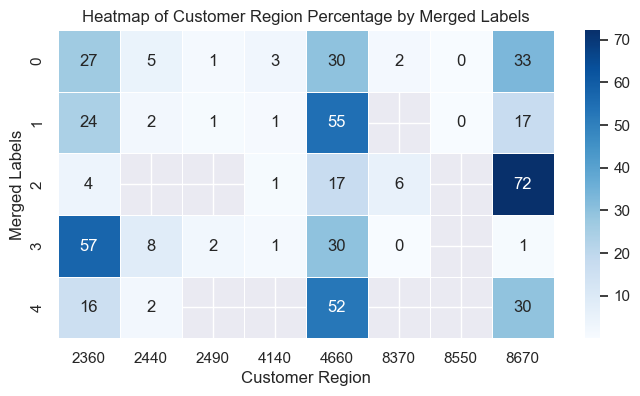

In [370]:
# Group by merged_labels and customer_region
df_cl_region = df_hc.groupby(['merged_labels', 'customer_region'])['customer_region'].size().unstack()

# Calculate the percentage distribution
df_cl_region_pct = df_cl_region.copy()
for i in df_hc['customer_region'].unique():
    df_cl_region_pct[i] = 100 * df_cl_region_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_cl_region_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of Customer Region Percentage by Merged Labels')
plt.xlabel('Customer Region')
plt.ylabel('Merged Labels')
plt.show()

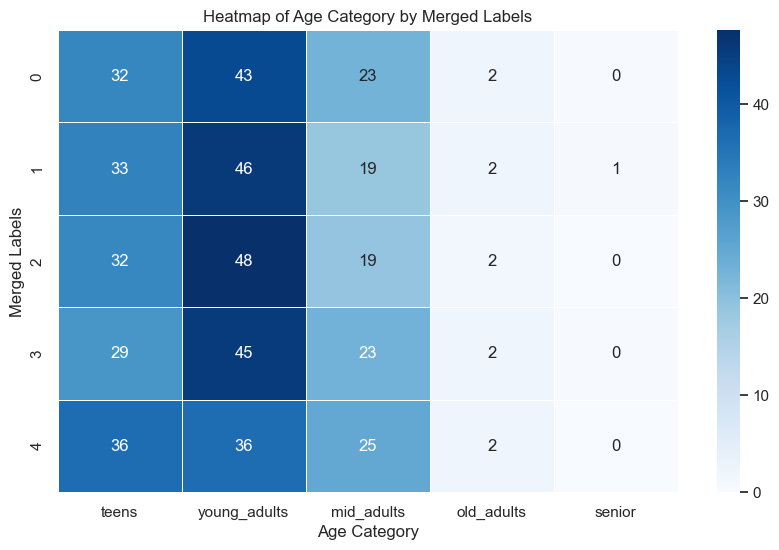

In [371]:
# Group by merged_labels and age_category
# Define the order of age categories from youngest to oldest
age_order = ['teens', 'young_adults', 'mid_adults', 'old_adults', 'senior']
df_hc['age_category'] = pd.Categorical(df_hc['age_category'], categories=age_order, ordered=True)

df_cl_age = df_hc.groupby(['merged_labels', 'age_category'])['age_category'].size().unstack()

# Reorder the columns based on the defined age order
df_cl_age = df_cl_age[age_order]

# Calculate the percentage distribution
df_cl_age_pct = df_cl_age.copy()
for i in df_hc['age_category'].unique():
    df_cl_age_pct[i] = 100 * df_cl_age_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_cl_age_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of Age Category by Merged Labels')
plt.xlabel('Age Category')
plt.ylabel('Merged Labels')
plt.show()